In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
os.chdir('..')
# sys.path.append(os.path.abspath(''))

### <span style="color: lightskyblue;"> Carga de datos </span>

In [3]:
import pandas as pd
from src.utils import clean_and_load
print(os.path.abspath('.'))
# hacer cd ..



trips_2020 = clean_and_load('data/raw/trips_2020.csv', drop_cols=['Unnamed: 0'])
trips_2021 = clean_and_load('data/raw/trips_2021.csv', drop_cols=['Unnamed: 0', 'genero'])  # eliminar segunda 'Género'
trips_2022 = clean_and_load('data/raw/trips_2022.csv', drop_cols=['Unnamed: 0', 'X'], rename_cols={'Género': 'genero'})
trips_2023 = clean_and_load('data/raw/trips_2023.csv', drop_cols=['Unnamed: 0'])
trips_2024 = clean_and_load('data/raw/trips_2024.csv')

trips_2020 = trips_2020[trips_2020['fecha_origen_recorrido'].dt.month > 8]

trips = pd.concat([trips_2020, trips_2021, trips_2022, trips_2023, trips_2024], ignore_index=True)

trips.to_csv('data/processed/trips.csv', index=False)

c:\Users\Matteo\Documents\Facultad\tercero\primercuatri\ML\ML\PF\proyecto_final


In [4]:

import pandas as pd

# Lista de archivos y si contienen o no la columna del DNI
user_files = [
    ('data/raw/usuarios_ecobici_2020.csv', True),
    ('data/raw/usuarios_ecobici_2021.csv', True),
    ('data/raw/usuarios_ecobici_2022.csv', True),
    ('data/raw/usuarios_ecobici_2023.csv', True),
    ('data/raw/usuarios_ecobici_2024.csv', False),  # este no tiene columna de DNI
]

user_dfs = []

for path, has_dni in user_files:
    df = pd.read_csv(path, parse_dates=['fecha_alta'])
    if has_dni:
        df.drop(columns=['Customer.Has.Dni..Yes...No.'], inplace=True)
    # Normalizar nombres de columnas
    df.columns = df.columns.str.lower().str.replace('.', '_').str.replace(' ', '').str.replace('__', '_')
    df = df.rename(columns={
        'id_usuario': 'id_usuario',
        'genero_usuario': 'genero_usuario',
        'edad_usuario': 'edad_usuario',
        'fecha_alta': 'fecha_alta',
        'hora_alta': 'hora_alta',
    })

    user_dfs.append(df)

# Concatenar todos los usuarios
usuarios = pd.concat(user_dfs, ignore_index=True)

# Convertir id_usuario a string para hacer merge correcto
usuarios['id_usuario'] = usuarios['id_usuario'].astype(float)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\2079243983.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, parse_dates=['fecha_alta'])


In [6]:
# Nos aseguramos que los id_usuario de trips también sean string
trips = pd.read_csv('data/processed/trips.csv')
trips['id_usuario'] = trips['id_usuario'].astype(float)
# usuarios edad entre 10 y 100
# Paso 1: Convertir todo a string
usuarios['edad_usuario'] = usuarios['edad_usuario'].astype(str)

# Paso 2: Eliminar comas, espacios y valores vacíos
usuarios['edad_usuario'] = usuarios['edad_usuario'].str.replace(',', '', regex=False).str.strip()

# Paso 3: Filtrar solo los valores que son dígitos (descarta "NaN", "dos mil", etc.)
usuarios = usuarios[usuarios['edad_usuario'].str.isdigit()]

# Paso 4: Convertir a int
usuarios['edad_usuario'] = usuarios['edad_usuario'].astype(int)

# Paso 5: Filtrar valores fuera del rango 10–100
usuarios = usuarios[(usuarios['edad_usuario'] >= 10) & (usuarios['edad_usuario'] <= 100)]



# Hacemos un left join: cada recorrido se enriquece con datos del usuario
trips_enriched = trips.merge(
    usuarios[['id_usuario', 'edad_usuario', 'fecha_alta', 'hora_alta']],
    on='id_usuario',
    how='left'
)
# trips_2024_filtered = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month <= 8]
# trips_2024_test = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month >= 9]
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
trips_enriched_train = trips_enriched[trips_enriched['fecha_origen_recorrido'].dt.month <= 8]
trips_2024_test = trips_enriched[trips_enriched['fecha_origen_recorrido'].dt.month >= 9]
trips_enriched = trips_enriched_train
# df = df.groupby("nombre_estacion_origen").filter(
#     lambda x: x["direccion_estacion_origen"].nunique() > 1
# )
usuarios

C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\2247460405.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv('data/processed/trips.csv')


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,735944.0,FEMALE,29,2020-12-31,20:19:04
1,735892.0,MALE,44,2020-12-31,11:24:04
2,735873.0,MALE,39,2020-12-31,09:28:27
3,735876.0,MALE,37,2020-12-31,09:49:30
4,735952.0,OTHER,29,2020-12-31,21:07:04
...,...,...,...,...,...
627876,1120417.0,FEMALE,45,2024-03-01,15:09:21
627877,1153589.0,MALE,55,2024-05-08,18:17:14
627878,1216661.0,MALE,25,2024-09-28,09:23:29
627879,1256657.0,MALE,24,2024-11-22,19:38:23


In [7]:
trips_enriched.to_csv('data/processed/trips_enriched.csv', index=False)
trips_2024_test.to_csv('data/processed/trips_2024_test.csv', index=False)

In [5]:
import pandas as pd

# trips_enriched = pd.read_csv('data/processed/trips_enriched.csv')
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
# trips_enriched.to_csv('data/processed/trips_enriched.csv', index=False)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_22100\3433263776.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_enriched = pd.read_csv('data/processed/trips_enriched.csv')


## <span style="color: lightskyblue;"> 2. Transformación a Series Temporales (30 min) </span>

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

def create_time_series_dataset_fast(trips_df, time_window_minutes=30):
    """
    Versión optimizada de transformación de dataset de viajes a series temporales.
    """
    trips_df = trips_df.copy()

    trips_df['fecha_origen_recorrido'] = pd.to_datetime(trips_df['fecha_origen_recorrido'])
    trips_df['fecha_destino_recorrido'] = pd.to_datetime(trips_df['fecha_destino_recorrido'])
    
    # 1. Crear columnas de ventana para despachos (origen) y arribos (destino)
    # trips_df['timestamp_origen_window'] = trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T')
    trips_df['timestamp_origen_window'] = (trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))

    trips_df['timestamp_destino_window'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T')
    trips_df['timestamp_destino_prev'] = (
    trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
    arribos_prev = trips_df.groupby(['timestamp_destino_prev','id_estacion_destino']).size().reset_index(name='arribos_prev_count').rename(columns={'timestamp_destino_prev':'timestamp','id_estacion_destino':'id_estacion'})

    # 2. Obtener rango de timestamps
    fecha_min = trips_df['timestamp_origen_window'].min()
    fecha_max = trips_df['timestamp_destino_window'].max()
    timestamps = pd.date_range(start=fecha_min, end=fecha_max, freq=f'{time_window_minutes}T')
    
    # 3. Obtener lista única de estaciones (origen + destino)
    estaciones_origen = trips_df[['id_estacion_origen', 'nombre_estacion_origen',
                                  'direccion_estacion_origen', 'lat_estacion_origen',
                                  'long_estacion_origen']].drop_duplicates()
    estaciones_destino = trips_df[['id_estacion_destino', 'nombre_estacion_destino',
                                   'direccion_estacion_destino', 'lat_estacion_destino',
                                   'long_estacion_destino']].drop_duplicates()

    estaciones_origen.columns = ['id_estacion', 'nombre_estacion', 'direccion_estacion', 'lat_estacion', 'long_estacion']
    estaciones_destino.columns = ['id_estacion', 'nombre_estacion', 'direccion_estacion', 'lat_estacion', 'long_estacion']
    
    estaciones = pd.concat([estaciones_origen, estaciones_destino]).drop_duplicates(subset=['id_estacion']).dropna(subset=['id_estacion'])

    print(f"Total de timestamps: {len(timestamps)}")
    print(f"Total de estaciones: {len(estaciones)}")
    
    # 4. Crear esqueleto base con producto cartesiano entre timestamps y estaciones
    timestamps_df = pd.DataFrame({'timestamp': timestamps})
    ts_grid = timestamps_df.assign(key=1).merge(estaciones.assign(key=1), on='key').drop(columns='key')

    # 5. Precalcular estadísticas históricas (ventana de despachos)
    despachos = trips_df.groupby(['timestamp_origen_window', 'id_estacion_origen']).agg(
        despachos_count=('id_estacion_origen', 'count'),
        duracion_recorrido_mean=('duracion_recorrido', 'mean'),
        duracion_recorrido_std=('duracion_recorrido', 'std'),
        duracion_recorrido_count=('duracion_recorrido', 'count'),
        edad_usuario_mean=('edad_usuario', 'mean'),
        edad_usuario_std=('edad_usuario', 'std'),
        proporcion_mujeres=('genero', lambda x: (x == 'F').sum() / len(x) if len(x) > 0 else 0),
        modelo_mas_comun=('modelo_bicicleta', lambda x: x.mode()[0] if len(x.mode()) > 0 else 'UNKNOWN')
    ).reset_index()

    despachos = despachos.rename(columns={
        'timestamp_origen_window': 'timestamp',
        'id_estacion_origen': 'id_estacion'
    })

    # 6. Precalcular arribos (ventana futura)
    arribos = trips_df.groupby(['timestamp_destino_window', 'id_estacion_destino']).size().reset_index(name='arribos_count')
    arribos = arribos.rename(columns={
        'timestamp_destino_window': 'timestamp',
        'id_estacion_destino': 'id_estacion'
    })

    # 7. Merge de todas las features al grid base
    ts_df = ts_grid.merge(despachos, on=['timestamp', 'id_estacion'], how='left')
    ts_df = ts_df.merge(arribos, on=['timestamp', 'id_estacion'], how='left')
    ts_df = ts_df.merge(arribos_prev, on=['timestamp','id_estacion'], how='left')
    ts_df['arribos_prev_count'] = ts_df['arribos_prev_count'].fillna(0).astype(int)

    # 8. Rellenar NaNs con valores por defecto
    ts_df['despachos_count'] = ts_df['despachos_count'].fillna(0).astype(int)
    ts_df['arribos_count'] = ts_df['arribos_count'].fillna(0).astype(int)
    ts_df['duracion_recorrido_mean'] = ts_df['duracion_recorrido_mean'].fillna(0)
    ts_df['duracion_recorrido_std'] = ts_df['duracion_recorrido_std'].fillna(0)
    ts_df['duracion_recorrido_count'] = ts_df['duracion_recorrido_count'].fillna(0).astype(int)
    ts_df['edad_usuario_mean'] = ts_df['edad_usuario_mean'].fillna(0)
    ts_df['edad_usuario_std'] = ts_df['edad_usuario_std'].fillna(0)
    ts_df['proporcion_mujeres'] = ts_df['proporcion_mujeres'].fillna(0)
    ts_df['modelo_mas_comun'] = ts_df['modelo_mas_comun'].fillna('UNKNOWN')

    # 9. Agregar variables temporales
    ts_df['hora'] = ts_df['timestamp'].dt.hour
    ts_df['dia_semana'] = ts_df['timestamp'].dt.dayofweek
    ts_df['es_fin_semana'] = (ts_df['dia_semana'] >= 5).astype(int)
    ts_df['mes'] = ts_df['timestamp'].dt.month
    ts_df['dia_mes'] = ts_df['timestamp'].dt.day
    ts_df['año'] = ts_df['timestamp'].dt.year

    print(f"\nDataset final:")
    print(f"Forma: {ts_df.shape}")
    print(f"Rango temporal: {ts_df['timestamp'].min()} a {ts_df['timestamp'].max()}")
    print(f"Estaciones únicas: {ts_df['id_estacion'].nunique()}")
    
            # 10. Crear columnas "prev_1" hasta "prev_6" para todas las features históricas
    features_to_shift = [
        'despachos_count', 'duracion_recorrido_mean', 'duracion_recorrido_std',
        'duracion_recorrido_count', 'edad_usuario_mean', 'edad_usuario_std',
        'proporcion_mujeres', 'arribos_count'
    ]

    ts_df = ts_df.sort_values(['id_estacion', 'timestamp'])

    # Crear columnas prev_1 a prev_6
    for lag in range(1, 7):  # De 1 a 6
        shifted = ts_df.groupby('id_estacion')[features_to_shift].shift(lag)
        shifted.columns = [f'{col}_prev_{lag}' for col in shifted.columns]
        ts_df = pd.concat([ts_df, shifted], axis=1)

    # Rellenar NaNs con valores neutros
    for col in ts_df.columns:
        if col.startswith(tuple(f"{f}_" for f in features_to_shift)) and col.endswith(tuple(f"_prev_{i}" for i in range(1, 7))):
            if ts_df[col].dtype == 'float':
                ts_df[col] = ts_df[col].fillna(0.0)
            else:
                ts_df[col] = ts_df[col].fillna(0)



    return ts_df

# Ejecutar transformación
print("Iniciando transformación de trips_enriched a series temporales...")
trips_enriched_ts = create_time_series_dataset_fast(trips_enriched, time_window_minutes=30)

# Guardar resultado
trips_enriched_ts.to_csv('data/processed/trips_enriched_timeseries.csv', index=False)
print(f"\nDataset guardado en: data/processed/trips_enriched_timeseries.csv")

trips_enriched_ts

Iniciando transformación de trips_enriched a series temporales...


C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\1835046342.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_origen_window'] = (trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\1835046342.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_destino_window'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T')
C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\1835046342.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\1835046342.py:26: FutureWarning: 'T' is deprecated an

Total de timestamps: 64929
Total de estaciones: 397


In [30]:

import gc

gc.collect()

0

## <span style="color: lightskyblue;"> 3. Split Train/Val y Normalización </span>

In [2]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import random

def split_train_val_by_week(df, random_seed=42):
    """
    Separa los datos en train y val usando 1 día random por semana para validación.
    """
    
    # Establecer semilla para reproducibilidad
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    print("Iniciando separación train/val...")
    print(f"Dataset original: {df.shape}")
    print(f"Rango temporal: {df['timestamp'].min()} a {df['timestamp'].max()}")
    
    # Crear columnas auxiliares para la separación
    df_work = df.copy()
    df_work['fecha'] = df_work['timestamp'].dt.date
    df_work['año'] = df_work['timestamp'].dt.year
    df_work['mes'] = df_work['timestamp'].dt.month
    df_work['semana_año'] = df_work['timestamp'].dt.isocalendar().week
    df_work['dia_semana'] = df_work['timestamp'].dt.dayofweek  # 0=Lunes, 6=Domingo
    
    # Obtener todas las combinaciones únicas de año-mes-semana
    semanas_unicas = df_work[['año', 'mes', 'semana_año']].drop_duplicates()
    
    print(f"Total de semanas únicas: {len(semanas_unicas)}")
    
    # Para cada semana, seleccionar un día aleatorio para validación
    dias_val = []
    
    for _, semana in semanas_unicas.iterrows():
        año, mes, num_semana = semana['año'], semana['mes'], semana['semana_año']
        
        # Obtener todos los días de esta semana en este mes
        dias_semana = df_work[
            (df_work['año'] == año) & 
            (df_work['mes'] == mes) & 
            (df_work['semana_año'] == num_semana)
        ]['fecha'].unique()
        
        if len(dias_semana) > 0:
            # Seleccionar un día aleatorio de esta semana
            dia_seleccionado = random.choice(dias_semana)
            dias_val.append(dia_seleccionado)
            
    print(f"Días seleccionados para validación: {len(dias_val)}")
    
    # Crear máscaras para train y val
    mask_val = df_work['fecha'].isin(dias_val)
    mask_train = ~mask_val
    
    # Separar los datasets
    train_df = df_work[mask_train].drop(columns=['fecha', 'semana_año']).reset_index(drop=True)
    val_df = df_work[mask_val].drop(columns=['fecha', 'semana_año']).reset_index(drop=True)
    
    print(f"Dataset train: {train_df.shape} ({mask_train.sum()/len(df)*100:.1f}%)")
    print(f"Dataset val: {val_df.shape} ({mask_val.sum()/len(df)*100:.1f}%)")
    
    # Verificar que no hay solapamiento temporal
    train_dates = set(train_df['timestamp'].dt.date)
    val_dates = set(val_df['timestamp'].dt.date)
    overlap = train_dates.intersection(val_dates)
    
    if len(overlap) > 0:
        print(f"⚠️  ADVERTENCIA: Hay {len(overlap)} días que aparecen en ambos conjuntos")
    else:
        print("✅ Separación correcta: No hay solapamiento de días entre train y val")
        
    return train_df, val_df


In [7]:
def normalize_features(train_df, val_df, exclude_cols=None):
    """
    Normaliza las features numéricas usando StandardScaler.
    """
    
    if exclude_cols is None:
        exclude_cols = ['timestamp', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
    
    print("\nIniciando normalización...")
    
    # Identificar columnas numéricas para normalizar
    numeric_cols = []
    categorical_cols = []
    
    for col in train_df.columns:
        if col in exclude_cols:
            continue
        elif train_df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    
    print(f"Columnas numéricas a normalizar: {len(numeric_cols)}")
    print(f"Columnas categóricas (no normalizadas): {len(categorical_cols)}")
    print(f"Columnas excluidas: {len(exclude_cols)}")
    
    # Crear copias para no modificar los originales
    train_norm = train_df.copy()
    val_norm = val_df.copy()
    
    # Inicializar y ajustar el scaler SOLO con datos de train
    scaler = StandardScaler()
    
    if len(numeric_cols) > 0:
        # Fit del scaler solo en train
        scaler.fit(train_norm[numeric_cols])
        
        # Transform en ambos conjuntos
        train_norm[numeric_cols] = scaler.transform(train_norm[numeric_cols])
        val_norm[numeric_cols] = scaler.transform(val_norm[numeric_cols])
        
        print(f"✅ Normalización completada")
        print(f"   Media de features train (debe ser ~0): {train_norm[numeric_cols].mean().mean():.6f}")
        print(f"   Std de features train (debe ser ~1): {train_norm[numeric_cols].std().mean():.6f}")
    else:
        print("⚠️  No se encontraron columnas numéricas para normalizar")
    
    return train_norm, val_norm, scaler, numeric_cols

# Ejecutar separación y normalización
print("=" * 60)
print("SEPARACIÓN TRAIN/VAL Y NORMALIZACIÓN")
print("=" * 60)
trips_enriched_ts = pd.read_csv('data/processed/trips_enriched_timeseries.csv', parse_dates=['timestamp'])
# 1. Separar train/val
train_raw, val_raw = split_train_val_by_week(trips_enriched_ts, random_seed=42)

# train_raw.to_csv('data/processed/train_raw.csv', index=False)
# val_raw.to_csv('data/processed/val_raw.csv', index=False)


SEPARACIÓN TRAIN/VAL Y NORMALIZACIÓN


C:\Users\Matteo\AppData\Local\Temp\ipykernel_32196\647774247.py:54: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_verano_ts = pd.read_csv('data/processed/trips_verano_timeseries.csv', parse_dates=['timestamp'])


Iniciando separación train/val...
Dataset original: (35189374, 70)
Rango temporal: 2020-01-01 00:30:00 a 2024-02-29 23:30:00
Total de semanas únicas: 260
Días seleccionados para validación: 260
Dataset train: (29174496, 70) (82.9%)
Dataset val: (6014878, 70) (17.1%)
✅ Separación correcta: No hay solapamiento de días entre train y val


KeyboardInterrupt: 

In [ ]:

# 2. Normalizar features
train_norm, val_norm, scaler, numeric_columns = normalize_features(train_raw, val_raw)

# 3. Guardar resultados
# train_norm.to_csv('data/processed/train_normalized.csv', index=False)
# val_norm.to_csv('data/processed/val_normalized.csv', index=False)

print(f"\n📁 Archivos guardados:")
print(f"   Train: data/processed/train_normalized.csv")
print(f"   Val: data/processed/val_normalized.csv")

# 4. Mostrar estadísticas finales
print(f"\n📊 Resumen final:")
print(f"   Train: {train_norm.shape[0]:,} filas × {train_norm.shape[1]:,} columnas")
print(f"   Val: {val_norm.shape[0]:,} filas × {val_norm.shape[1]:,} columnas")
print(f"   Proporción val: {len(val_norm)/len(trips_enriched_ts)*100:.1f}%")

# 5. Verificar distribución temporal
print(f"\n📅 Distribución temporal:")
print("Train por mes:")
print(train_norm['timestamp'].dt.month.value_counts().sort_index())
print("\nVal por mes:")
print(val_norm['timestamp'].dt.month.value_counts().sort_index())


## <span style="color: lightskyblue;"> 5. Entrenamiento XGBoost </span>

In [5]:
# dropear del train y del val todas las columnas que empiecen con nombre_estacion_ y direccion_estacion_

train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion_') or col.startswith('direccion_estacion_') or col.startswith('modelo_mas_comun_')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion_') or col.startswith('direccion_estacion_') or col.startswith('modelo_mas_comun_')])

In [6]:
# guardar train_df y val_df
train_norm.to_csv('data/processed/train_norm.csv', index=False)
val_norm.to_csv('data/processed/val_norm.csv', index=False)

# Modelo M0

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    # Remover features que contengan '_prev' en el nombre
    feature_cols = [col for col in feature_cols if '_prev' not in col]
    print(feature_cols)
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando distribución de Poisson.
    """
    print("\n🚀 Entrenando modelo XGBoost...")
    xgb_params = {
        'n_estimators': 1000,  # Aumentamos para dar margen al early stopping
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',  # Métrica a monitorear para early stopping
        'max_bin': 128, 
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=25,
    verbose=True
    )
    print(f"✅ Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n📈 Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n📊 MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
# 🚀 PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST\n" + "="*60)

# drop nombre_estacion: object, direccion_estacion: object, modelo_mas_comun: object
train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_norm, val_norm)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y target...
['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
X_train: (29174496, 13), y_train: (29174496,)
X_val: (6014878, 13), y_val: (6014878,)

🚀 Entrenando modelo XGBoost...


c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.06445
[1]	validation_0-rmse:1.03906
[2]	validation_0-rmse:1.01556
[3]	validation_0-rmse:0.99368
[4]	validation_0-rmse:0.97396
[5]	validation_0-rmse:0.95543
[6]	validation_0-rmse:0.93829
[7]	validation_0-rmse:0.92325
[8]	validation_0-rmse:0.91128
[9]	validation_0-rmse:0.89813
[10]	validation_0-rmse:0.88588
[11]	validation_0-rmse:0.87409
[12]	validation_0-rmse:0.86315
[13]	validation_0-rmse:0.85388
[14]	validation_0-rmse:0.84465
[15]	validation_0-rmse:0.83622
[16]	validation_0-rmse:0.82794
[17]	validation_0-rmse:0.82091
[18]	validation_0-rmse:0.81430
[19]	validation_0-rmse:0.80767
[20]	validation_0-rmse:0.80190
[21]	validation_0-rmse:0.79691
[22]	validation_0-rmse:0.79224
[23]	validation_0-rmse:0.78767
[24]	validation_0-rmse:0.78396
[25]	validation_0-rmse:0.77996
[26]	validation_0-rmse:0.77668
[27]	validation_0-rmse:0.77334
[28]	validation_0-rmse:0.77047
[29]	validation_0-rmse:0.76781
[30]	validation_0-rmse:0.76510
[31]	validation_0-rmse:0.76319
[32]	validation_0-


GENERANDO VISUALIZACIONES DE RESULTADOS


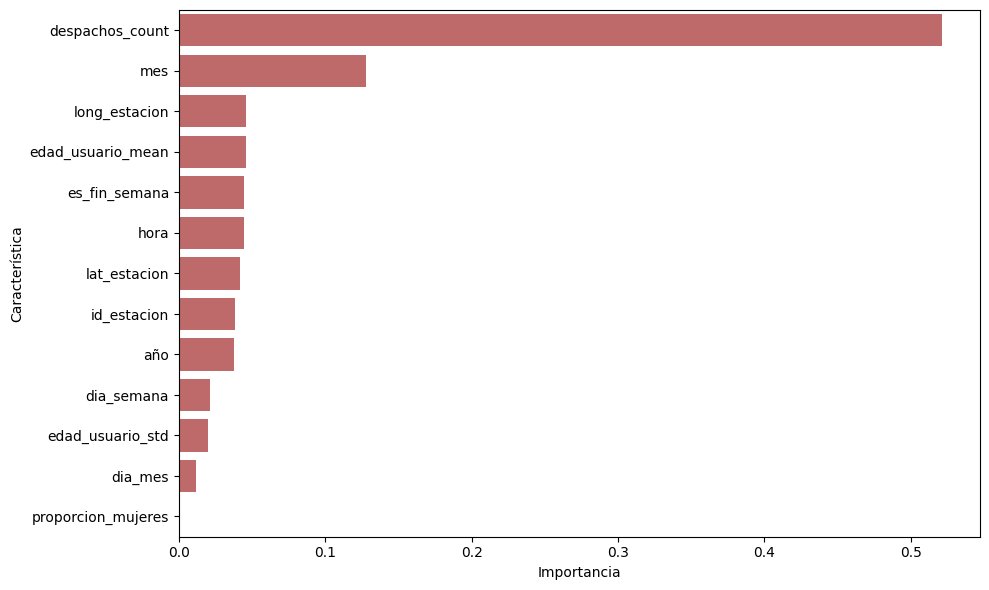

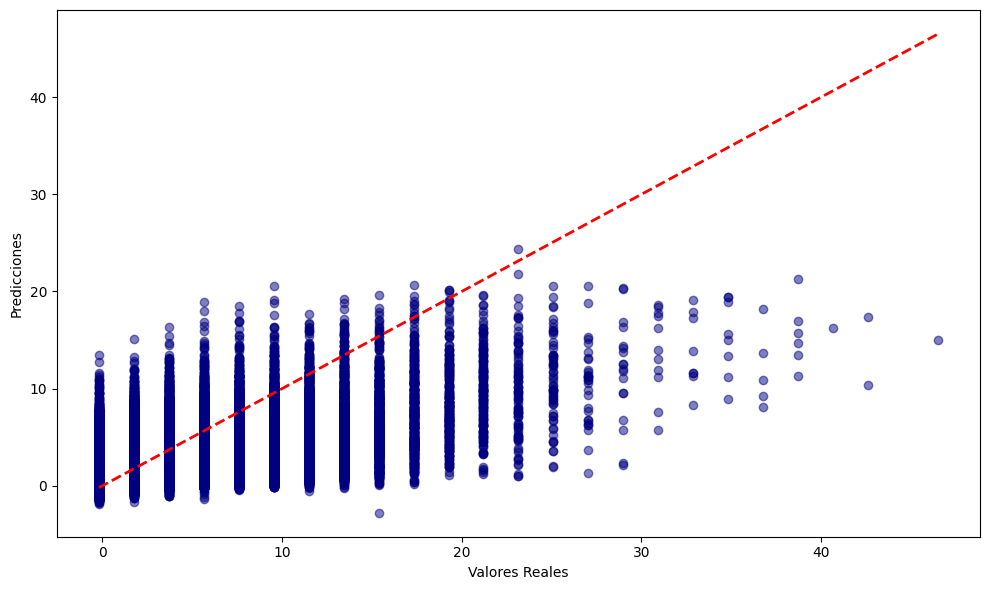


🏆 TOP 5 MEJORES ESTACIONES (R2):
                MSE       MAE        R2
-0.628443  2.938076  0.626014  0.691285
-0.323424  3.012189  0.585354  0.660961
-1.673295  2.850742  0.651292  0.653447
-1.575948  2.303499  0.565285  0.642478
 1.584565  0.637600  0.143369  0.640966

⚠️ TOP 5 PEORES ESTACIONES (R2):
                MSE       MAE            R2
-0.037875  0.003231  0.024316 -4.194095e+30
 0.857712  0.010968  0.030085 -2.471127e-01
 0.968038  0.011075  0.031068 -2.187044e-01
 1.662442  0.010874  0.021304 -1.567852e-01
 0.065961  0.029915  0.059357 -1.502722e-01


In [20]:
# ================================================================
# 📊 VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_norm['id_estacion'].unique():
    mask = val_norm['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

# Modelo M1
### Agregar features de intervalos previos

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando distribución de Poisson.
    """
    print("\n🚀 Entrenando modelo XGBoost...")
    xgb_params = {
        'n_estimators': 1000,  # Aumentamos para dar margen al early stopping
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',  # Métrica a monitorear para early stopping
        'max_bin': 128, 
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=25,
    verbose=True
    )
    print(f"✅ Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n📈 Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n📊 MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
# 🚀 PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST\n" + "="*60)

# drop nombre_estacion: object, direccion_estacion: object, modelo_mas_comun: object
train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_norm, val_norm)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)

# 4. Guardar modelo
print("\n💾 Guardando modelo...")
model_info = {
    'model': model,
    'features': feature_cols,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': metrics
}
with open('data/processed/xgb_model_single_output.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✅ Modelo guardado en data/processed/xgb_model_single_output.pkl")


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', 'arribos_coun

c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.06154
[1]	validation_0-rmse:1.03376
[2]	validation_0-rmse:1.00804
[3]	validation_0-rmse:0.98431
[4]	validation_0-rmse:0.96213
[5]	validation_0-rmse:0.94171
[6]	validation_0-rmse:0.92273
[7]	validation_0-rmse:0.90540
[8]	validation_0-rmse:0.88920
[9]	validation_0-rmse:0.87431
[10]	validation_0-rmse:0.86064
[11]	validation_0-rmse:0.84799
[12]	validation_0-rmse:0.83631
[13]	validation_0-rmse:0.82560
[14]	validation_0-rmse:0.81572
[15]	validation_0-rmse:0.80664
[16]	validation_0-rmse:0.79833
[17]	validation_0-rmse:0.79072
[18]	validation_0-rmse:0.78375
[19]	validation_0-rmse:0.77735
[20]	validation_0-rmse:0.77164
[21]	validation_0-rmse:0.76623
[22]	validation_0-rmse:0.76146
[23]	validation_0-rmse:0.75714
[24]	validation_0-rmse:0.75294
[25]	validation_0-rmse:0.74902
[26]	validation_0-rmse:0.74548
[27]	validation_0-rmse:0.74248
[28]	validation_0-rmse:0.73969
[29]	validation_0-rmse:0.73715
[30]	validation_0-rmse:0.73459
[31]	validation_0-rmse:0.73249
[32]	validation_0-


GENERANDO VISUALIZACIONES DE RESULTADOS


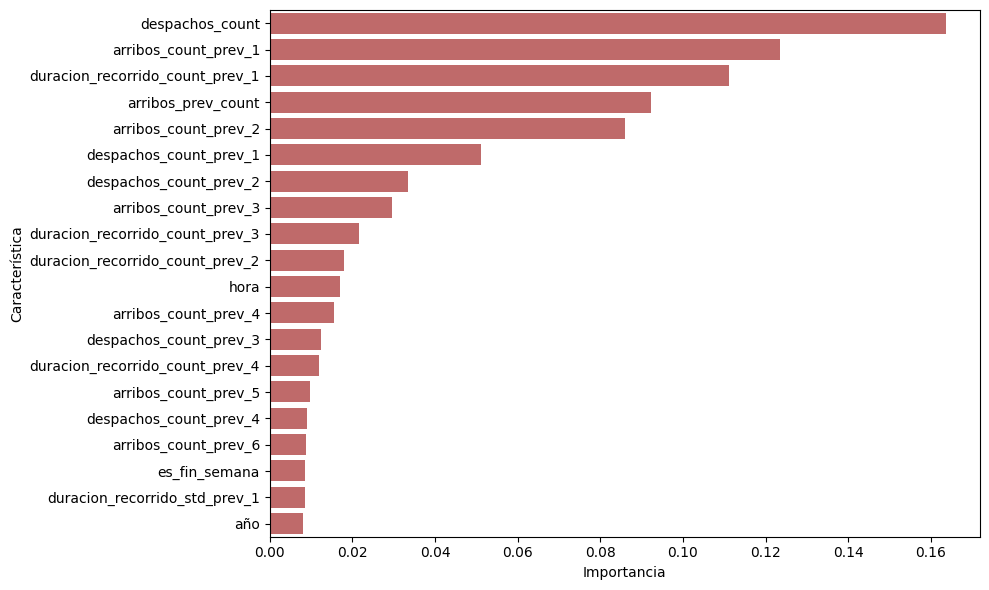

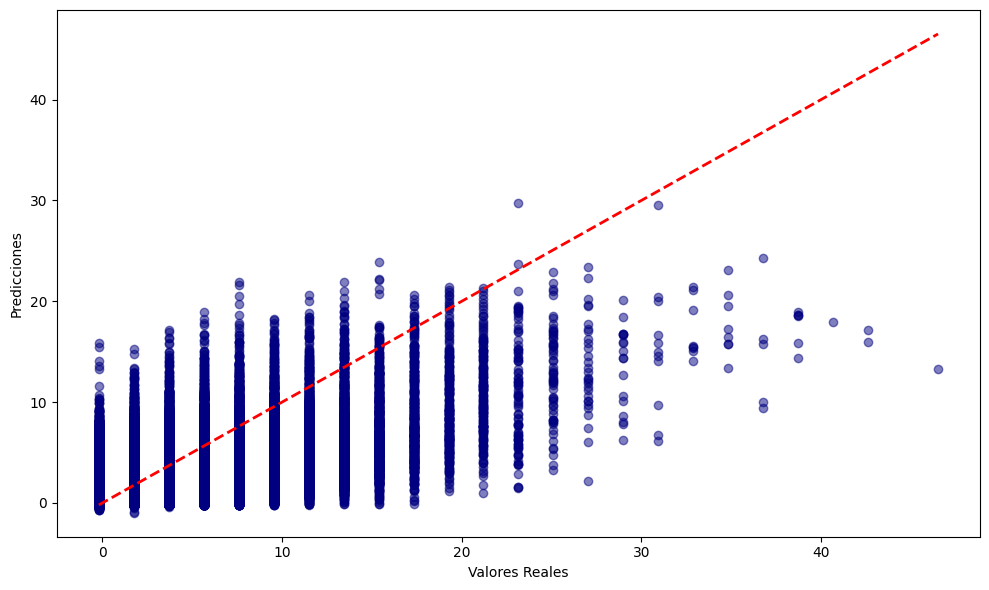


🏆 TOP 5 MEJORES ESTACIONES (R2):
                MSE       MAE        R2
-0.628443  2.726364  0.589838  0.713530
-0.323424  2.811878  0.553970  0.683507
-1.673295  2.781618  0.632404  0.661850
 1.584565  0.601259  0.123180  0.661430
 0.033512  2.013123  0.497871  0.658122

⚠️ TOP 5 PEORES ESTACIONES (R2):
                MSE       MAE            R2
-0.037875  0.000771  0.013082 -1.000485e+30
 0.857712  0.010985  0.018883 -2.489727e-01
 0.968038  0.010134  0.020489 -1.151738e-01
 0.065961  0.028818  0.034247 -1.080768e-01
 1.662442  0.009930  0.013960 -5.642979e-02


In [27]:
# ================================================================
# 📊 VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_norm['id_estacion'].unique():
    mask = val_norm['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    # Chequeo de no-negatividad
    assert (y_train >= 0).all(), "y_train contiene valores negativos, Poisson no lo soporta."
    assert (y_val >= 0).all(), "y_val contiene valores negativos, Poisson no lo soporta."
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando Poisson como función de pérdida.
    """
    print("\n🚀 Entrenando modelo XGBoost con pérdida Poisson...")

    xgb_params = {
        'n_estimators': 1500,
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',
        'max_bin': 128,
        'objective': 'count:poisson',  # <= CAMBIO CLAVE
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=25,
        verbose=True
    )
    print(f"✅ Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n📈 Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n📊 MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
# 🚀 PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST CON POISSON\n" + "="*60)

# drop columnas innecesarias
train_raw = train_raw.drop(columns=[col for col in train_raw.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_raw = val_raw.drop(columns=[col for col in val_raw.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_raw, val_raw)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)

# 4. Guardar modelo
print("\n💾 Guardando modelo...")
model_info = {
    'model': model,
    'features': feature_cols,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': metrics
}
with open('data/processed/xgb_model_poisson.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✅ Modelo guardado en data/processed/xgb_model_poisson.pkl")


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST CON POISSON
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', '

c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.62799
[1]	validation_0-rmse:0.61796
[2]	validation_0-rmse:0.60828
[3]	validation_0-rmse:0.59896
[4]	validation_0-rmse:0.58991
[5]	validation_0-rmse:0.58117
[6]	validation_0-rmse:0.57272
[7]	validation_0-rmse:0.56461
[8]	validation_0-rmse:0.55673
[9]	validation_0-rmse:0.54913
[10]	validation_0-rmse:0.54181
[11]	validation_0-rmse:0.53474
[12]	validation_0-rmse:0.52790
[13]	validation_0-rmse:0.52132
[14]	validation_0-rmse:0.51495
[15]	validation_0-rmse:0.50882
[16]	validation_0-rmse:0.50290
[17]	validation_0-rmse:0.49721
[18]	validation_0-rmse:0.49171
[19]	validation_0-rmse:0.48644
[20]	validation_0-rmse:0.48139
[21]	validation_0-rmse:0.47649
[22]	validation_0-rmse:0.47182
[23]	validation_0-rmse:0.46735
[24]	validation_0-rmse:0.46298
[25]	validation_0-rmse:0.45877
[26]	validation_0-rmse:0.45472
[27]	validation_0-rmse:0.45089
[28]	validation_0-rmse:0.44720
[29]	validation_0-rmse:0.44366
[30]	validation_0-rmse:0.44020
[31]	validation_0-rmse:0.43694
[32]	validation_0-


GENERANDO VISUALIZACIONES DE RESULTADOS


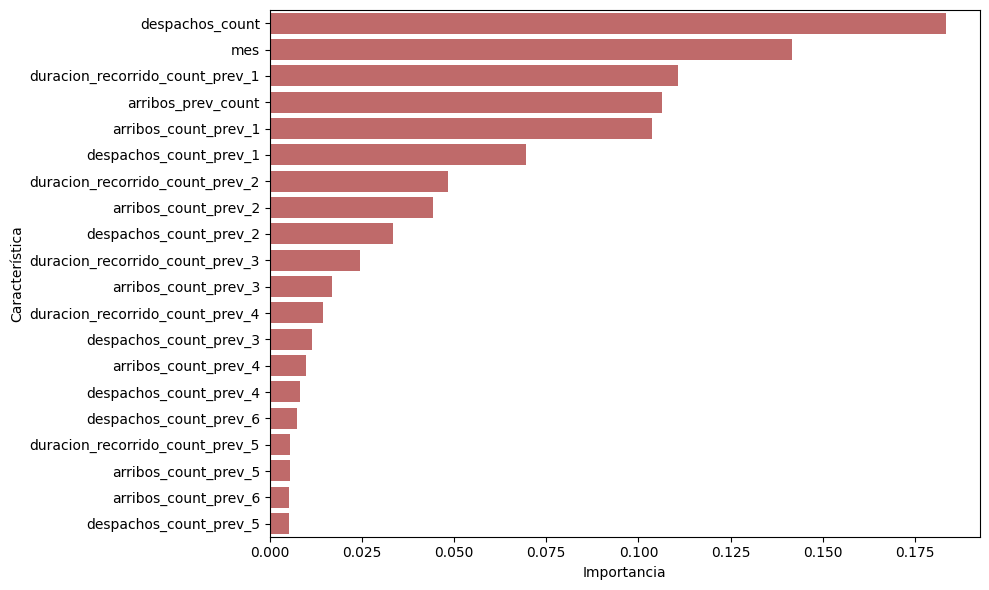

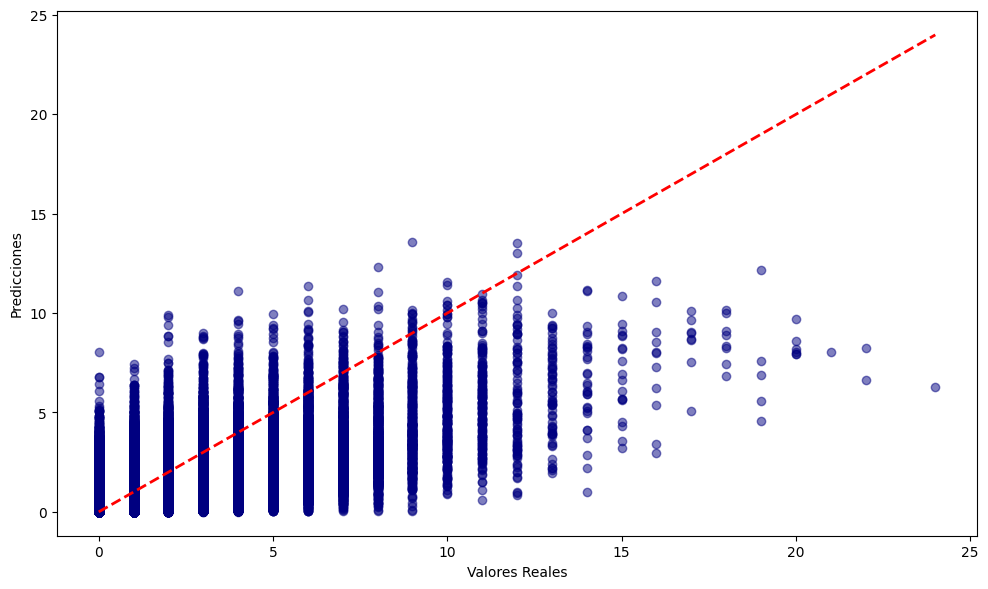


🏆 TOP 5 MEJORES ESTACIONES (R2):
          MSE       MAE        R2
175  0.719542  0.300313  0.713520
222  0.750879  0.281815  0.679757
516  0.154009  0.059916  0.671394
14   0.725263  0.318619  0.665921
277  0.525081  0.252223  0.662115

⚠️ TOP 5 PEORES ESTACIONES (R2):
          MSE       MAE        R2
266  0.000005  0.000808  0.000000
447  0.012059  0.009399  0.002304
528  0.002459  0.004250  0.008664
404  0.002273  0.003989  0.020624
482  0.015532  0.018825  0.058291


In [ ]:
# ================================================================
# 📊 VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_raw['id_estacion'].unique():
    mask = val_raw['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import time

def prepare_features_and_targets(train_df, val_df):
    """
    Separa las features X y targets Y de los datasets.
    """
    
    print("Preparando features y targets...")
    
    # Identificar columnas de arribos (targets Y)
    target_cols = [col for col in train_df.columns if col.startswith('arribos_count_')]
    
    # Identificar columnas de features (X) - todo excepto arribos y columnas temporales básicas
    exclude_cols = ['timestamp'] + target_cols
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    print(f"Features (X): {len(feature_cols)} columnas")
    print(f"Targets (Y): {len(target_cols)} columnas")
    print(f"Excluidas: {len(exclude_cols)} columnas")
    
    # Separar X e Y para train
    X_train = train_df[feature_cols]
    y_train = train_df[target_cols]
    
    # Separar X e Y para val
    X_val = val_df[feature_cols]
    y_val = val_df[target_cols]
    
    print(f"\nShapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}")
    print(f"y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols, target_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost multi-output.
    """
    
    print("\n" + "="*60)
    print("ENTRENAMIENTO XGBOOST")
    print("="*60)
    
    # Configuración del modelo XGBoost
    xgb_params = {
        'n_estimators': 100,           # Número de árboles
        'max_depth': 6,                # Profundidad máxima
        'learning_rate': 0.1,          # Tasa de aprendizaje
        'subsample': 0.8,              # Submuestreo de filas
        'colsample_bytree': 0.8,       # Submuestreo de columnas
        'random_state': 42,            # Reproducibilidad
        'n_jobs': 8,                  # Usar todos los cores
        'verbosity': 1,                 # Nivel de verbosidad
        'tree_method': 'gpu_hist'
    }
    
    print("Configuración XGBoost:")
    for param, value in xgb_params.items():
        print(f"  {param}: {value}")
    
    # Crear el modelo base
    xgb_base = xgb.XGBRegressor(**xgb_params)
    
    # Envolver en MultiOutputRegressor para manejar múltiples targets
    model = MultiOutputRegressor(xgb_base, n_jobs=8)
    
    print(f"\nIniciando entrenamiento...")
    start_time = time.time()
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")
    
    return model

def evaluate_model(model, X_train, y_train, X_val, y_val, target_cols):
    """
    Evalúa el rendimiento del modelo.
    """
    
    print("\n" + "="*60)
    print("EVALUACIÓN DEL MODELO")
    print("="*60)
    
    # Predicciones
    print("Generando predicciones...")
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Métricas para el conjunto de entrenamiento
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Métricas para el conjunto de validación
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"\n📊 MÉTRICAS GLOBALES:")
    print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
    print("-" * 50)
    print(f"{'Train':<12} {train_mse:<12.4f} {train_mae:<12.4f} {train_r2:<12.4f}")
    print(f"{'Validación':<12} {val_mse:<12.4f} {val_mae:<12.4f} {val_r2:<12.4f}")
    
    # Análisis por estación (Top 10 estaciones con más arribos)
    print(f"\n📍 ANÁLISIS POR ESTACIÓN (Top 10):")
    
    # Calcular total de arribos reales por estación
    station_totals = y_val.sum().sort_values(ascending=False).head(10)
    
    print(f"{'Estación':<15} {'MSE':<10} {'MAE':<10} {'R²':<10} {'Total Arribos':<15}")
    print("-" * 70)
    
    for i, (station_col, total_arribos) in enumerate(station_totals.items()):
        station_idx = list(y_val.columns).index(station_col)
        
        station_mse = mean_squared_error(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        station_mae = mean_absolute_error(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        station_r2 = r2_score(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        
        station_name = station_col.replace('arribos_count_', '')[:12]
        print(f"{station_name:<15} {station_mse:<10.3f} {station_mae:<10.3f} {station_r2:<10.3f} {total_arribos:<15.0f}")
    
    # Resumen de overfitting
    print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
    overfitting_mse = (train_mse - val_mse) / val_mse * 100
    overfitting_mae = (train_mae - val_mae) / val_mae * 100
    
    print(f"Diferencia MSE: {overfitting_mse:.2f}% ({'Overfitting' if overfitting_mse < -10 else 'OK'})")
    print(f"Diferencia MAE: {overfitting_mae:.2f}% ({'Overfitting' if overfitting_mae < -10 else 'OK'})")
    
    return {
        'train_mse': train_mse, 'train_mae': train_mae, 'train_r2': train_r2,
        'val_mse': val_mse, 'val_mae': val_mae, 'val_r2': val_r2,
        'y_train_pred': y_train_pred, 'y_val_pred': y_val_pred
    }

# Ejecutar pipeline completo
print("🚀 INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST")
print("="*60)

# 1. Preparar features y targets
X_train, y_train, X_val, y_val, feature_cols, target_cols = prepare_features_and_targets(train_norm, val_norm)

# 2. Entrenar modelo
xgb_model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
results = evaluate_model(xgb_model, X_train, y_train, X_val, y_val, target_cols)

# 4. Guardar modelo y metadatos
print("\n💾 Guardando modelo...")

model_info = {
    'model': xgb_model,
    'feature_columns': feature_cols,
    'target_columns': target_cols,
    'scaler': scaler,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': {
        'val_mse': results['val_mse'],
        'val_mae': results['val_mae'], 
        'val_r2': results['val_r2']
    }
}

with open('data/processed/xgb_model.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("✅ Modelo guardado en: data/processed/xgb_model.pkl")

print(f"\n🎉 ENTRENAMIENTO COMPLETADO")
print(f"Modelo entrenado con {len(feature_cols)} features para predecir {len(target_cols)} targets")
print(f"R² en validación: {results['val_r2']:.4f}")


🚀 INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y targets...
Features (X): 4344 columnas
Targets (Y): 482 columnas
Excluidas: 483 columnas

Shapes:
X_train: (60528, 4344)
y_train: (60528, 482)
X_val: (12480, 4344)
y_val: (12480, 482)

ENTRENAMIENTO XGBOOST
Configuración XGBoost:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: 8
  verbosity: 1
  tree_method: gpu_hist

Iniciando entrenamiento...
✅ Entrenamiento completado en 4584.61 segundos

EVALUACIÓN DEL MODELO
Generando predicciones...

📊 MÉTRICAS GLOBALES:
Conjunto     MSE          MAE          R²          
--------------------------------------------------
Train        0.2034       0.1297       0.7966      
Validación   0.5853       0.1903       0.3649      

📍 ANÁLISIS POR ESTACIÓN (Top 10):
Estación        MSE        MAE        R²         Total Arribos  
----------------------------------------------------------------------
522.0      

## <span style="color: lightskyblue;"> 4. Modelado con Proceso de Poisson Global </span>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')
df_ts = trips_enriched_ts.copy()
# Cargar datos de series temporales
print("Cargando datos de series temporales...")
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
# df_ts = pd.read_csv('data/processed/trips_verano_timeseries.csv')
df_ts = create_time_series_dataset_fast(trips_enriched)
df_ts['timestamp'] = pd.to_datetime(df_ts['timestamp'])

print(f"Datos cargados: {df_ts.shape}")
print(f"Rango temporal: {df_ts['timestamp'].min()} a {df_ts['timestamp'].max()}")
print(f"Total de estaciones: {df_ts['id_estacion'].nunique()}")

# Visualizar estructura básica
print("\nPrimeras 3 filas:")
print(df_ts.head(3))

print("\nInfo básica del dataset:")
print(df_ts.info())


Cargando datos de series temporales...


KeyError: 'fecha_origen_recorrido'

📊 ANÁLISIS GLOBAL DE DESPACHOS
Total de ventanas temporales: 62783
Despachos promedio por ventana: 47.58
Despachos máximos en una ventana: 689
Despachos mínimos en una ventana: 0

📈 Estadísticas descriptivas:
count    62783.000000
mean        47.579775
std        103.535783
min          0.000000
25%          0.000000
50%          0.000000
75%         24.000000
max        689.000000
Name: despachos_count, dtype: float64


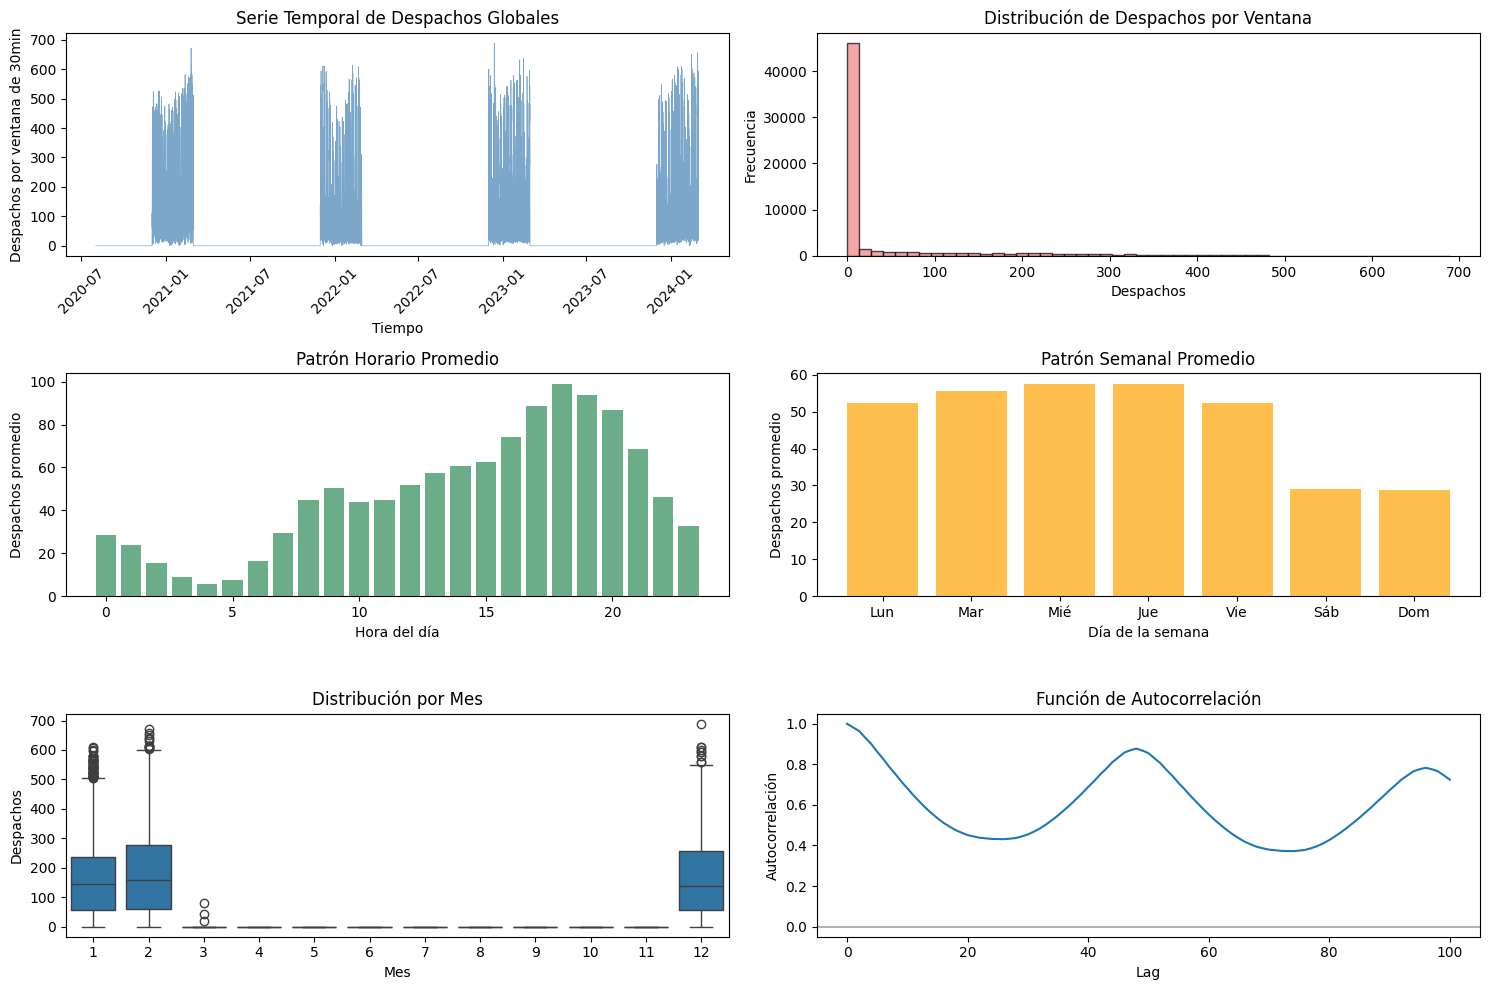


🔍 ANÁLISIS DE VARIABILIDAD:
Varianza: 10719.66
Desviación estándar: 103.54
Coeficiente de variación: 2.176


In [ ]:
### Análisis Global de Despachos: Proceso de Poisson
df_ts = df_ts[df_ts['timestamp'] > '2020-08-01']
# Agregar un conteo global de despachos por ventana de tiempo
print("📊 ANÁLISIS GLOBAL DE DESPACHOS")
print("="*50)

# Agregamos todos los despachos por timestamp para obtener la demanda global
despachos_globales = df_ts.groupby('timestamp')['despachos_count'].sum().reset_index()
despachos_globales = despachos_globales.sort_values('timestamp')

print(f"Total de ventanas temporales: {len(despachos_globales)}")
print(f"Despachos promedio por ventana: {despachos_globales['despachos_count'].mean():.2f}")
print(f"Despachos máximos en una ventana: {despachos_globales['despachos_count'].max()}")
print(f"Despachos mínimos en una ventana: {despachos_globales['despachos_count'].min()}")

# Estadísticas descriptivas
print("\n📈 Estadísticas descriptivas:")
print(despachos_globales['despachos_count'].describe())

# Visualización
plt.figure(figsize=(15, 10))

# Subplot 1: Serie temporal completa
plt.subplot(3, 2, 1)
plt.plot(despachos_globales['timestamp'], despachos_globales['despachos_count'], 
         linewidth=0.5, alpha=0.7, color='steelblue')
plt.title('Serie Temporal de Despachos Globales')
plt.xlabel('Tiempo')
plt.ylabel('Despachos por ventana de 30min')
plt.xticks(rotation=45)

# Subplot 2: Histograma
plt.subplot(3, 2, 2)
plt.hist(despachos_globales['despachos_count'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribución de Despachos por Ventana')
plt.xlabel('Despachos')
plt.ylabel('Frecuencia')

# Subplot 3: Patrones por hora
despachos_globales['hora'] = despachos_globales['timestamp'].dt.hour
hourly_pattern = despachos_globales.groupby('hora')['despachos_count'].mean()

plt.subplot(3, 2, 3)
plt.bar(hourly_pattern.index, hourly_pattern.values, alpha=0.7, color='seagreen')
plt.title('Patrón Horario Promedio')
plt.xlabel('Hora del día')
plt.ylabel('Despachos promedio')

# Subplot 4: Patrones por día de la semana
despachos_globales['dia_semana'] = despachos_globales['timestamp'].dt.dayofweek
daily_pattern = despachos_globales.groupby('dia_semana')['despachos_count'].mean()
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

plt.subplot(3, 2, 4)
plt.bar(range(7), daily_pattern.values, alpha=0.7, color='orange')
plt.title('Patrón Semanal Promedio')
plt.xlabel('Día de la semana')
plt.ylabel('Despachos promedio')
plt.xticks(range(7), dias)

# Subplot 5: Box plot por mes
despachos_globales['mes'] = despachos_globales['timestamp'].dt.month
plt.subplot(3, 2, 5)
sns.boxplot(data=despachos_globales, x='mes', y='despachos_count')
plt.title('Distribución por Mes')
plt.xlabel('Mes')   
plt.ylabel('Despachos')

# Subplot 6: Autocorrelación (primeros 100 lags)
from statsmodels.tsa.stattools import acf
plt.subplot(3, 2, 6)
autocorr = acf(despachos_globales['despachos_count'], nlags=100)
plt.plot(autocorr)
plt.title('Función de Autocorrelación')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n🔍 ANÁLISIS DE VARIABILIDAD:")
print(f"Varianza: {despachos_globales['despachos_count'].var():.2f}")
print(f"Desviación estándar: {despachos_globales['despachos_count'].std():.2f}")
print(f"Coeficiente de variación: {despachos_globales['despachos_count'].std()/despachos_globales['despachos_count'].mean():.3f}")


🎯 MODELADO DEL PROCESO DE POISSON GLOBAL
Ajustando modelo de Poisson global...
0.2407103107030966

📊 RESULTADOS DEL MODELO DE POISSON:
Lambda estimado (tasa promedio): 47.5798
Varianza teórica (debe ≈ lambda): 47.5798
Varianza observada: 10719.6584
Ratio varianza/media (debe ≈ 1 para Poisson): 225.2986

🧪 TESTS DE BONDAD DE AJUSTE:
Kolmogorov-Smirnov:
  Estadístico: 0.757018
  p-valor: 0.000000
  Ajuste: ❌ Pobre (α=0.05)


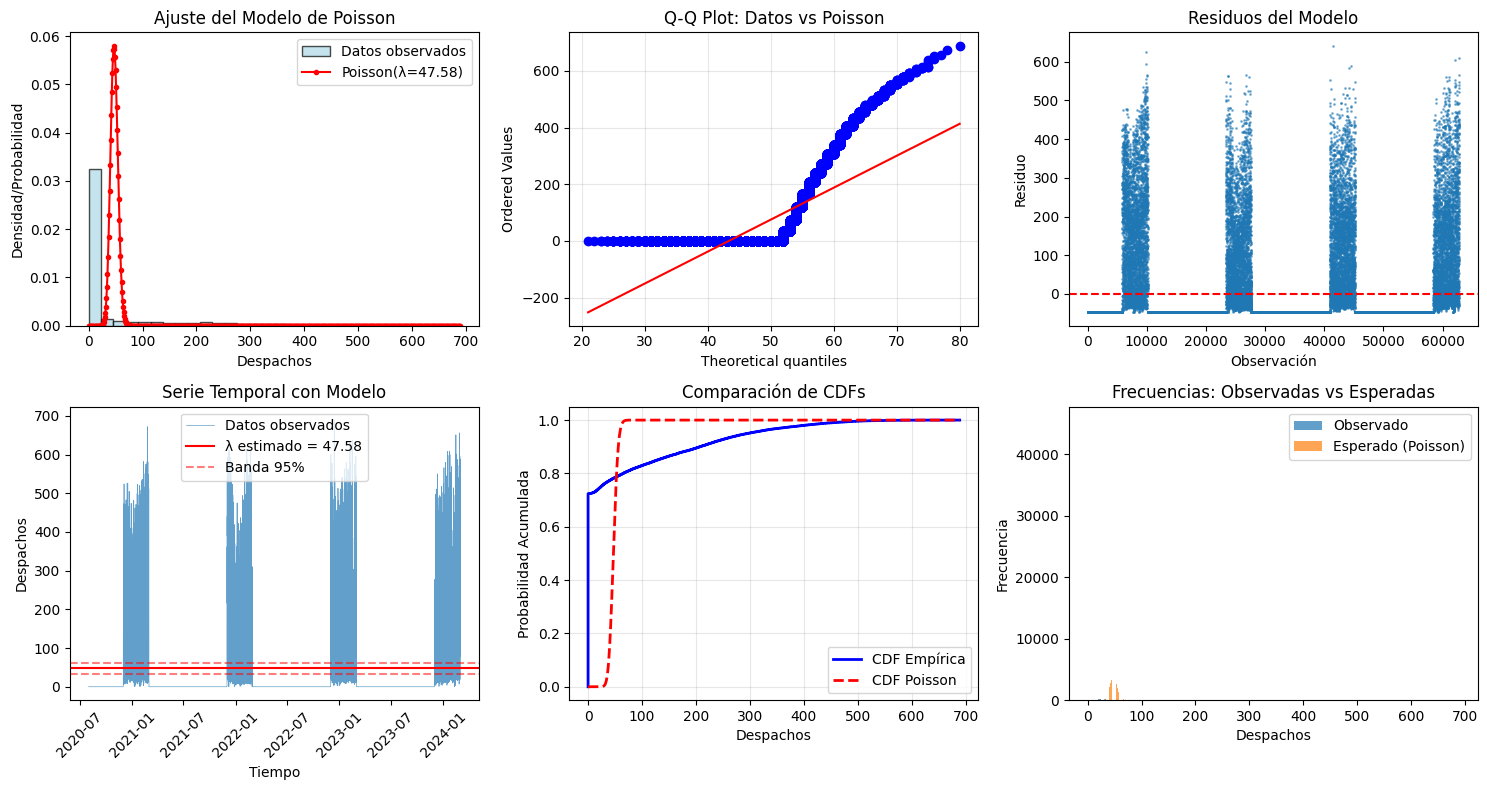


💡 INTERPRETACIÓN DEL MODELO:
• El sistema tiene una tasa promedio de 47.58 despachos cada 30 minutos
• En términos horarios: ~95.2 despachos por hora
• En términos diarios: ~2284 despachos por día (24h)
• ⚠️  Sobredispersión detectada (ratio = 225.299), considerar modelos alternativos

💾 Modelo Poisson global guardado en memoria para uso posterior


In [ ]:
print("🎯 MODELADO DEL PROCESO DE POISSON GLOBAL")
print("="*60)

def fit_poisson_model(data):
    """
    Ajusta un modelo de Poisson a los datos y calcula estadísticas.
    """
    # Estimar lambda (parámetro de la distribución de Poisson)
    lambda_est = data.mean()
    
    # Test de bondad de ajuste Kolmogorov-Smirnov
    from scipy.stats import kstest, poisson
    ks_stat, ks_pvalue = kstest(data, lambda x: poisson.cdf(x, lambda_est))
    
    # Chi-cuadrado test
    from scipy.stats import chisquare
    try:
        # Crear bins más robustos
        max_val = min(int(data.max()), int(lambda_est) + 20)  # Limitar rango para evitar bins vacíos
        bins = np.arange(max_val + 2)
        
        # Calcular frecuencias observadas
        observed_freq, _ = np.histogram(data, bins=bins)
        
        # Calcular frecuencias esperadas
        expected_freq = []
        for i in range(len(observed_freq)):
            prob = poisson.pmf(bins[i], lambda_est)
            expected_freq.append(prob * len(data))
        
        expected_freq = np.array(expected_freq)
        
        # Combinar bins con frecuencia esperada baja
        combined_observed = []
        combined_expected = []
        temp_obs = 0
        temp_exp = 0
        
        for i in range(len(observed_freq)):
            temp_obs += observed_freq[i]
            temp_exp += expected_freq[i]
            
            if temp_exp >= 5 or i == len(observed_freq) - 1:
                combined_observed.append(temp_obs)
                combined_expected.append(temp_exp)
                temp_obs = 0
                temp_exp = 0
        
        combined_observed = np.array(combined_observed)
        combined_expected = np.array(combined_expected)
        
        if len(combined_observed) >= 2:
            chi2_stat, chi2_pvalue = chisquare(combined_observed, combined_expected)
        else:
            chi2_stat, chi2_pvalue = np.nan, np.nan
            
    except Exception as e:
        print(f"Warning: Chi-cuadrado test falló: {e}")
        chi2_stat, chi2_pvalue = np.nan, np.nan
        # Usar valores originales para visualización
        bins = range(int(data.max()) + 2)
        observed_freq, _ = np.histogram(data, bins=bins)
        expected_freq = [poisson.pmf(i, lambda_est) * len(data) for i in range(len(observed_freq))]
    
    
    return {
        'lambda': lambda_est,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'chi2_statistic': chi2_stat,
        'chi2_pvalue': chi2_pvalue,
        'observed_freq': observed_freq,
        'expected_freq': expected_freq,
        'bins': bins
    }

# Ajustar modelo de Poisson global
print("Ajustando modelo de Poisson global...")
poisson_results = fit_poisson_model(despachos_globales['despachos_count'])

print(f"\n📊 RESULTADOS DEL MODELO DE POISSON:")
print(f"Lambda estimado (tasa promedio): {poisson_results['lambda']:.4f}")
print(f"Varianza teórica (debe ≈ lambda): {poisson_results['lambda']:.4f}")
print(f"Varianza observada: {despachos_globales['despachos_count'].var():.4f}")
print(f"Ratio varianza/media (debe ≈ 1 para Poisson): {despachos_globales['despachos_count'].var()/despachos_globales['despachos_count'].mean():.4f}")

print(f"\n🧪 TESTS DE BONDAD DE AJUSTE:")
print(f"Kolmogorov-Smirnov:")
print(f"  Estadístico: {poisson_results['ks_statistic']:.6f}")
print(f"  p-valor: {poisson_results['ks_pvalue']:.6f}")
print(f"  Ajuste: {'✅ Bueno' if poisson_results['ks_pvalue'] > 0.05 else '❌ Pobre'} (α=0.05)")

if not np.isnan(poisson_results['chi2_pvalue']):
    print(f"Chi-cuadrado:")
    print(f"  Estadístico: {poisson_results['chi2_statistic']:.6f}")
    print(f"  p-valor: {poisson_results['chi2_pvalue']:.6f}")
    print(f"  Ajuste: {'✅ Bueno' if poisson_results['chi2_pvalue'] > 0.05 else '❌ Pobre'} (α=0.05)")

# Visualización del ajuste
plt.figure(figsize=(15, 8))

# Subplot 1: Histograma vs distribución teórica
plt.subplot(2, 3, 1)
plt.hist(despachos_globales['despachos_count'], bins=30, density=True, alpha=0.7, 
         color='lightblue', edgecolor='black', label='Datos observados')

# Superponer distribución de Poisson teórica
x_range = np.arange(0, despachos_globales['despachos_count'].max() + 1)
poisson_pmf = stats.poisson.pmf(x_range, poisson_results['lambda'])
plt.plot(x_range, poisson_pmf, 'ro-', markersize=3, label=f'Poisson(λ={poisson_results["lambda"]:.2f})')
plt.title('Ajuste del Modelo de Poisson')
plt.xlabel('Despachos')
plt.ylabel('Densidad/Probabilidad')
plt.legend()

# Subplot 2: Q-Q plot
plt.subplot(2, 3, 2)
from scipy.stats import probplot
probplot(despachos_globales['despachos_count'], dist=stats.poisson, 
         sparams=(poisson_results['lambda'],), plot=plt)
plt.title('Q-Q Plot: Datos vs Poisson')
plt.grid(True, alpha=0.3)

# Subplot 3: Residuos
plt.subplot(2, 3, 3)
expected_values = np.full(len(despachos_globales), poisson_results['lambda'])
residuals = despachos_globales['despachos_count'] - expected_values
plt.scatter(range(len(residuals)), residuals, alpha=0.5, s=1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos del Modelo')
plt.xlabel('Observación')
plt.ylabel('Residuo')

# Subplot 4: Serie temporal con banda de confianza
plt.subplot(2, 3, 4)
lambda_est = poisson_results['lambda']
upper_bound = lambda_est + 2*np.sqrt(lambda_est)  # ~95% confianza
lower_bound = max(0, lambda_est - 2*np.sqrt(lambda_est))

plt.plot(despachos_globales['timestamp'], despachos_globales['despachos_count'], 
         linewidth=0.5, alpha=0.7, label='Datos observados')
plt.axhline(y=lambda_est, color='red', linestyle='-', label=f'λ estimado = {lambda_est:.2f}')
plt.axhline(y=upper_bound, color='red', linestyle='--', alpha=0.5, label='Banda 95%')
plt.axhline(y=lower_bound, color='red', linestyle='--', alpha=0.5)
plt.title('Serie Temporal con Modelo')
plt.xlabel('Tiempo')
plt.ylabel('Despachos')
plt.legend()
plt.xticks(rotation=45)

# Subplot 5: Comparación acumulativa
plt.subplot(2, 3, 5)
sorted_data = np.sort(despachos_globales['despachos_count'])
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
theoretical_cdf = stats.poisson.cdf(sorted_data, poisson_results['lambda'])

plt.plot(sorted_data, empirical_cdf, 'b-', label='CDF Empírica', linewidth=2)
plt.plot(sorted_data, theoretical_cdf, 'r--', label='CDF Poisson', linewidth=2)
plt.title('Comparación de CDFs')
plt.xlabel('Despachos')
plt.ylabel('Probabilidad Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Frecuencias observadas vs esperadas
plt.subplot(2, 3, 6)
# Convertir bins a array numpy para poder hacer operaciones
bins_array = np.array(list(poisson_results['bins'][:-1])) if isinstance(poisson_results['bins'], range) else poisson_results['bins'][:-1]
x_vals = bins_array
plt.bar(x_vals, poisson_results['observed_freq'], alpha=0.7, label='Observado', width=0.4)
plt.bar(x_vals + 0.4, poisson_results['expected_freq'], alpha=0.7, label='Esperado (Poisson)', width=0.4)
plt.title('Frecuencias: Observadas vs Esperadas')
plt.xlabel('Despachos')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

# Interpretación del modelo
print(f"\n💡 INTERPRETACIÓN DEL MODELO:")
print(f"• El sistema tiene una tasa promedio de {poisson_results['lambda']:.2f} despachos cada 30 minutos")
print(f"• En términos horarios: ~{poisson_results['lambda']*2:.1f} despachos por hora")
print(f"• En términos diarios: ~{poisson_results['lambda']*48:.0f} despachos por día (24h)")

ratio_var_mean = despachos_globales['despachos_count'].var()/despachos_globales['despachos_count'].mean()
if abs(ratio_var_mean - 1) < 0.1:
    print(f"• ✅ El ratio varianza/media ≈ 1, sugiere que el proceso Poisson es apropiado")
elif ratio_var_mean > 1.1:
    print(f"• ⚠️  Sobredispersión detectada (ratio = {ratio_var_mean:.3f}), considerar modelos alternativos")
else:
    print(f"• ⚠️  Subdispersión detectada (ratio = {ratio_var_mean:.3f}), considerar modelos alternativos")

# Guardar resultados del modelo
model_results = {
    'model_type': 'poisson_global',
    'lambda_estimated': poisson_results['lambda'],
    'timestamp_range': (despachos_globales['timestamp'].min(), despachos_globales['timestamp'].max()),
    'n_observations': len(despachos_globales),
    'goodness_of_fit': {
        'ks_statistic': poisson_results['ks_statistic'],
        'ks_pvalue': poisson_results['ks_pvalue'],
        'chi2_statistic': poisson_results['chi2_statistic'],
        'chi2_pvalue': poisson_results['chi2_pvalue']
    },
    'variance_ratio': ratio_var_mean
}

print(f"\n💾 Modelo Poisson global guardado en memoria para uso posterior")


📊 ANÁLISIS GLOBAL DE ARRIBOS
Total de ventanas temporales: 62783
Arribos promedio por ventana: 47.58
Arribos máximos en una ventana: 697
Arribos mínimos en una ventana: 0

📈 Estadísticas descriptivas:
count    62783.000000
mean        47.580603
std        103.096592
min          0.000000
25%          0.000000
50%          0.000000
75%         25.000000
max        697.000000
Name: arribos_count, dtype: float64


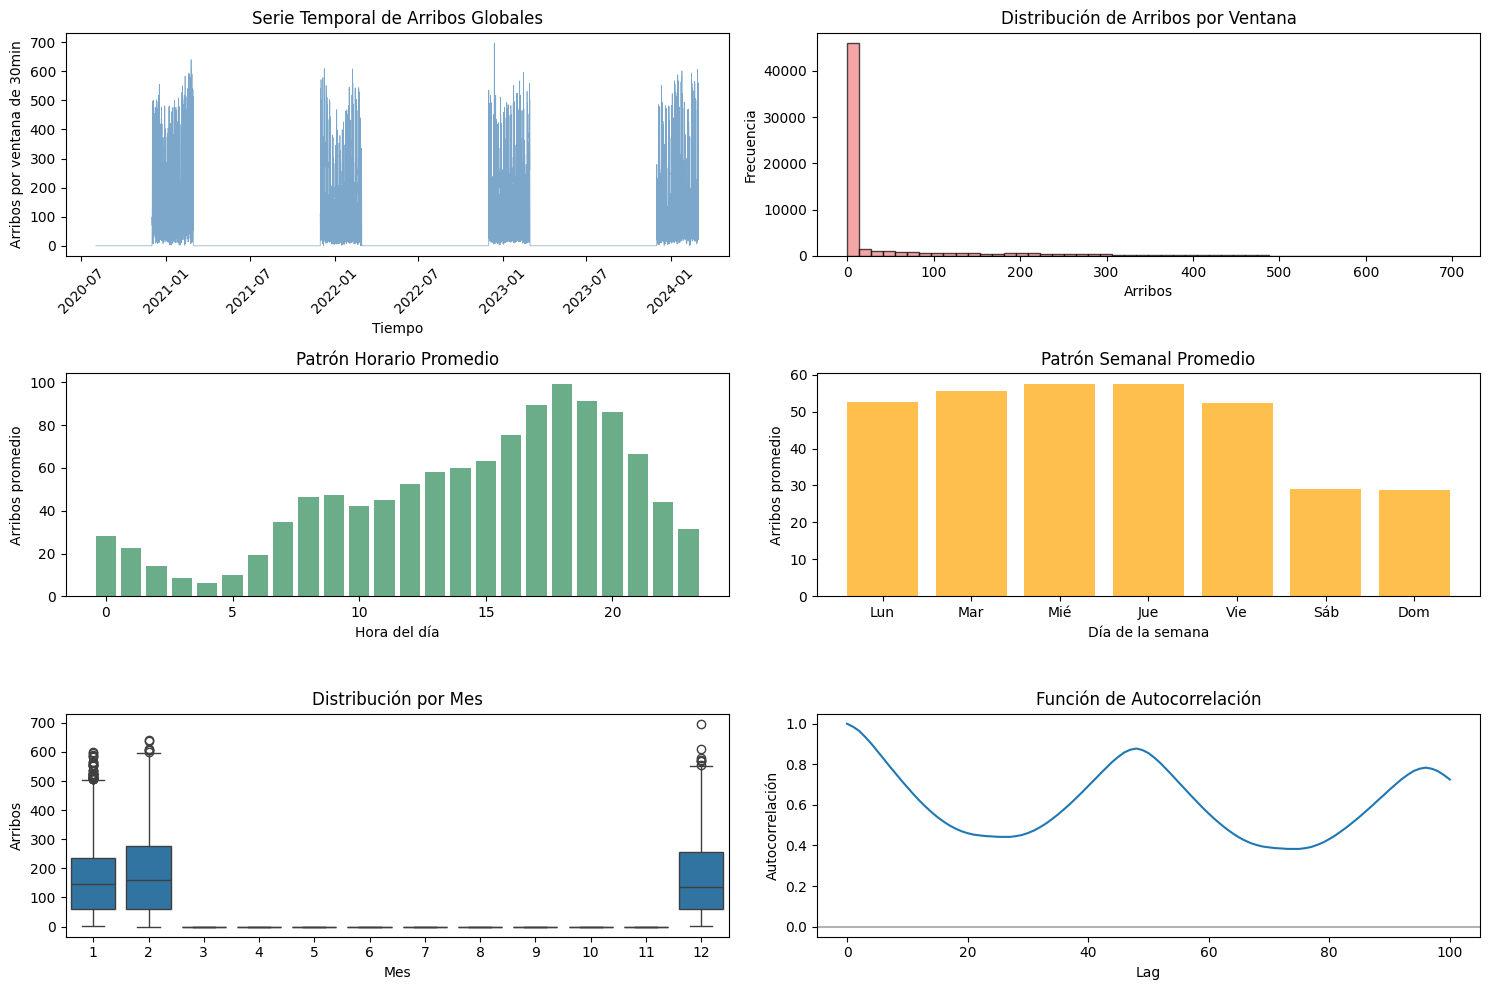


🔍 ANÁLISIS DE VARIABILIDAD:
Varianza: 10628.91
Desviación estándar: 103.10
Coeficiente de variación: 2.167


In [ ]:
### Análisis Global de Arribos: Proceso de Poisson
# Agregar un conteo global de arribos por ventana de tiempo
print("📊 ANÁLISIS GLOBAL DE ARRIBOS")
print("="*50)

# Agregamos todos los arribos por timestamp para obtener la demanda global de llegadas
arribos_globales = df_ts.groupby('timestamp')['arribos_count'].sum().reset_index()
arribos_globales = arribos_globales.sort_values('timestamp')

print(f"Total de ventanas temporales: {len(arribos_globales)}")
print(f"Arribos promedio por ventana: {arribos_globales['arribos_count'].mean():.2f}")
print(f"Arribos máximos en una ventana: {arribos_globales['arribos_count'].max()}")
print(f"Arribos mínimos en una ventana: {arribos_globales['arribos_count'].min()}")

# Estadísticas descriptivas
print("\n📈 Estadísticas descriptivas:")
print(arribos_globales['arribos_count'].describe())

# Visualización
plt.figure(figsize=(15, 10))

# Subplot 1: Serie temporal completa
plt.subplot(3, 2, 1)
plt.plot(arribos_globales['timestamp'], arribos_globales['arribos_count'], 
         linewidth=0.5, alpha=0.7, color='steelblue')
plt.title('Serie Temporal de Arribos Globales')
plt.xlabel('Tiempo')
plt.ylabel('Arribos por ventana de 30min')
plt.xticks(rotation=45)

# Subplot 2: Histograma
plt.subplot(3, 2, 2)
plt.hist(arribos_globales['arribos_count'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribución de Arribos por Ventana')
plt.xlabel('Arribos')
plt.ylabel('Frecuencia')

# Subplot 3: Patrones por hora
arribos_globales['hora'] = arribos_globales['timestamp'].dt.hour
hourly_pattern = arribos_globales.groupby('hora')['arribos_count'].mean()

plt.subplot(3, 2, 3)
plt.bar(hourly_pattern.index, hourly_pattern.values, alpha=0.7, color='seagreen')
plt.title('Patrón Horario Promedio')
plt.xlabel('Hora del día')
plt.ylabel('Arribos promedio')

# Subplot 4: Patrones por día de la semana
arribos_globales['dia_semana'] = arribos_globales['timestamp'].dt.dayofweek
daily_pattern = arribos_globales.groupby('dia_semana')['arribos_count'].mean()
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

plt.subplot(3, 2, 4)
plt.bar(range(7), daily_pattern.values, alpha=0.7, color='orange')
plt.title('Patrón Semanal Promedio')
plt.xlabel('Día de la semana')
plt.ylabel('Arribos promedio')
plt.xticks(range(7), dias)

# Subplot 5: Box plot por mes
arribos_globales['mes'] = arribos_globales['timestamp'].dt.month
plt.subplot(3, 2, 5)
sns.boxplot(data=arribos_globales, x='mes', y='arribos_count')
plt.title('Distribución por Mes')
plt.xlabel('Mes')
plt.ylabel('Arribos')

# Subplot 6: Autocorrelación (primeros 100 lags)
from statsmodels.tsa.stattools import acf
plt.subplot(3, 2, 6)
autocorr = acf(arribos_globales['arribos_count'], nlags=100)
plt.plot(autocorr)
plt.title('Función de Autocorrelación')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n🔍 ANÁLISIS DE VARIABILIDAD:")
print(f"Varianza: {arribos_globales['arribos_count'].var():.2f}")
print(f"Desviación estándar: {arribos_globales['arribos_count'].std():.2f}")
print(f"Coeficiente de variación: {arribos_globales['arribos_count'].std()/arribos_globales['arribos_count'].mean():.3f}")


🎯 MODELADO DEL PROCESO DE POISSON GLOBAL - ARRIBOS
Ajustando modelo de Poisson global para arribos...
0.24253150282622807

📊 RESULTADOS DEL MODELO DE POISSON PARA ARRIBOS:
Lambda estimado (tasa promedio): 47.5806
Varianza teórica (debe ≈ lambda): 47.5806
Varianza observada: 10628.9072
Ratio varianza/media (debe ≈ 1 para Poisson): 223.3874

🧪 TESTS DE BONDAD DE AJUSTE:
Kolmogorov-Smirnov:
  Estadístico: 0.755538
  p-valor: 0.000000
  Ajuste: ❌ Pobre (α=0.05)


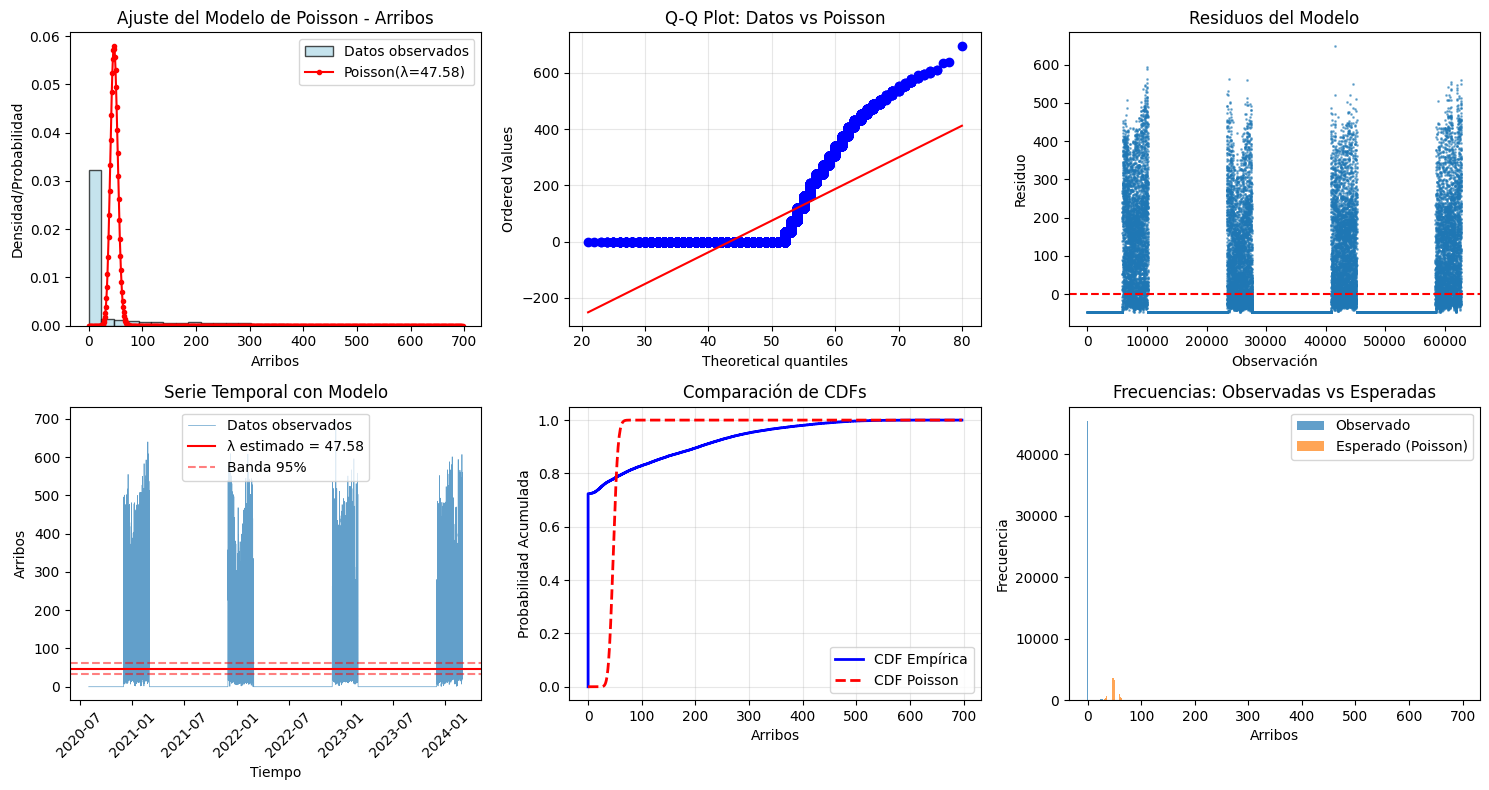


💡 INTERPRETACIÓN DEL MODELO DE ARRIBOS:
• El sistema tiene una tasa promedio de 47.58 arribos cada 30 minutos
• En términos horarios: ~95.2 arribos por hora
• En términos diarios: ~2284 arribos por día (24h)
• ⚠️  Sobredispersión detectada (ratio = 223.387), considerar modelos alternativos

💾 Modelo Poisson global de arribos guardado en memoria para uso posterior


In [ ]:
print("🎯 MODELADO DEL PROCESO DE POISSON GLOBAL - ARRIBOS")
print("="*60)

def fit_poisson_model(data):
    """
    Ajusta un modelo de Poisson a los datos y calcula estadísticas.
    """
    # Estimar lambda (parámetro de la distribución de Poisson)
    lambda_est = data.mean()
    
    # Test de bondad de ajuste Kolmogorov-Smirnov
    from scipy.stats import kstest, poisson
    ks_stat, ks_pvalue = kstest(data, lambda x: poisson.cdf(x, lambda_est))
    
    # Chi-cuadrado test
    from scipy.stats import chisquare
    try:
        # Crear bins más robustos
        max_val = min(int(data.max()), int(lambda_est) + 20)  # Limitar rango para evitar bins vacíos
        bins = np.arange(max_val + 2)
        
        # Calcular frecuencias observadas
        observed_freq, _ = np.histogram(data, bins=bins)
        
        # Calcular frecuencias esperadas
        expected_freq = []
        for i in range(len(observed_freq)):
            prob = poisson.pmf(bins[i], lambda_est)
            expected_freq.append(prob * len(data))
        
        expected_freq = np.array(expected_freq)
        
        # Combinar bins con frecuencia esperada baja
        combined_observed = []
        combined_expected = []
        temp_obs = 0
        temp_exp = 0
        
        for i in range(len(observed_freq)):
            temp_obs += observed_freq[i]
            temp_exp += expected_freq[i]
            
            if temp_exp >= 5 or i == len(observed_freq) - 1:
                combined_observed.append(temp_obs)
                combined_expected.append(temp_exp)
                temp_obs = 0
                temp_exp = 0
        
        combined_observed = np.array(combined_observed)
        combined_expected = np.array(combined_expected)
        
        if len(combined_observed) >= 2:
            chi2_stat, chi2_pvalue = chisquare(combined_observed, combined_expected)
        else:
            chi2_stat, chi2_pvalue = np.nan, np.nan
            
    except Exception as e:
        print(f"Warning: Chi-cuadrado test falló: {e}")
        chi2_stat, chi2_pvalue = np.nan, np.nan
        # Usar valores originales para visualización
        bins = range(int(data.max()) + 2)
        observed_freq, _ = np.histogram(data, bins=bins)
        expected_freq = [poisson.pmf(i, lambda_est) * len(data) for i in range(len(observed_freq))]
    
    
    return {
        'lambda': lambda_est,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'chi2_statistic': chi2_stat,
        'chi2_pvalue': chi2_pvalue,
        'observed_freq': observed_freq,
        'expected_freq': expected_freq,
        'bins': bins
    }

# Ajustar modelo de Poisson global para ARRIBOS
print("Ajustando modelo de Poisson global para arribos...")
poisson_results = fit_poisson_model(arribos_globales['arribos_count'])

print(f"\n📊 RESULTADOS DEL MODELO DE POISSON PARA ARRIBOS:")
print(f"Lambda estimado (tasa promedio): {poisson_results['lambda']:.4f}")
print(f"Varianza teórica (debe ≈ lambda): {poisson_results['lambda']:.4f}")
print(f"Varianza observada: {arribos_globales['arribos_count'].var():.4f}")
print(f"Ratio varianza/media (debe ≈ 1 para Poisson): {arribos_globales['arribos_count'].var()/arribos_globales['arribos_count'].mean():.4f}")

print(f"\n🧪 TESTS DE BONDAD DE AJUSTE:")
print(f"Kolmogorov-Smirnov:")
print(f"  Estadístico: {poisson_results['ks_statistic']:.6f}")
print(f"  p-valor: {poisson_results['ks_pvalue']:.6f}")
print(f"  Ajuste: {'✅ Bueno' if poisson_results['ks_pvalue'] > 0.05 else '❌ Pobre'} (α=0.05)")

if not np.isnan(poisson_results['chi2_pvalue']):
    print(f"Chi-cuadrado:")
    print(f"  Estadístico: {poisson_results['chi2_statistic']:.6f}")
    print(f"  p-valor: {poisson_results['chi2_pvalue']:.6f}")
    print(f"  Ajuste: {'✅ Bueno' if poisson_results['chi2_pvalue'] > 0.05 else '❌ Pobre'} (α=0.05)")

# Visualización del ajuste
plt.figure(figsize=(15, 8))

# Subplot 1: Histograma vs distribución teórica
plt.subplot(2, 3, 1)
plt.hist(arribos_globales['arribos_count'], bins=30, density=True, alpha=0.7, 
         color='lightblue', edgecolor='black', label='Datos observados')

# Superponer distribución de Poisson teórica
x_range = np.arange(0, arribos_globales['arribos_count'].max() + 1)
poisson_pmf = stats.poisson.pmf(x_range, poisson_results['lambda'])
plt.plot(x_range, poisson_pmf, 'ro-', markersize=3, label=f'Poisson(λ={poisson_results["lambda"]:.2f})')
plt.title('Ajuste del Modelo de Poisson - Arribos')
plt.xlabel('Arribos')
plt.ylabel('Densidad/Probabilidad')
plt.legend()

# Subplot 2: Q-Q plot
plt.subplot(2, 3, 2)
from scipy.stats import probplot
probplot(arribos_globales['arribos_count'], dist=stats.poisson, 
         sparams=(poisson_results['lambda'],), plot=plt)
plt.title('Q-Q Plot: Datos vs Poisson')
plt.grid(True, alpha=0.3)

# Subplot 3: Residuos
plt.subplot(2, 3, 3)
expected_values = np.full(len(arribos_globales), poisson_results['lambda'])
residuals = arribos_globales['arribos_count'] - expected_values
plt.scatter(range(len(residuals)), residuals, alpha=0.5, s=1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos del Modelo')
plt.xlabel('Observación')
plt.ylabel('Residuo')

# Subplot 4: Serie temporal con banda de confianza
plt.subplot(2, 3, 4)
lambda_est = poisson_results['lambda']
upper_bound = lambda_est + 2*np.sqrt(lambda_est)  # ~95% confianza
lower_bound = max(0, lambda_est - 2*np.sqrt(lambda_est))

plt.plot(arribos_globales['timestamp'], arribos_globales['arribos_count'], 
         linewidth=0.5, alpha=0.7, label='Datos observados')
plt.axhline(y=lambda_est, color='red', linestyle='-', label=f'λ estimado = {lambda_est:.2f}')
plt.axhline(y=upper_bound, color='red', linestyle='--', alpha=0.5, label='Banda 95%')
plt.axhline(y=lower_bound, color='red', linestyle='--', alpha=0.5)
plt.title('Serie Temporal con Modelo')
plt.xlabel('Tiempo')
plt.ylabel('Arribos')
plt.legend()
plt.xticks(rotation=45)

# Subplot 5: Comparación acumulativa
plt.subplot(2, 3, 5)
sorted_data = np.sort(arribos_globales['arribos_count'])
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
theoretical_cdf = stats.poisson.cdf(sorted_data, poisson_results['lambda'])

plt.plot(sorted_data, empirical_cdf, 'b-', label='CDF Empírica', linewidth=2)
plt.plot(sorted_data, theoretical_cdf, 'r--', label='CDF Poisson', linewidth=2)
plt.title('Comparación de CDFs')
plt.xlabel('Arribos')
plt.ylabel('Probabilidad Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Frecuencias observadas vs esperadas
plt.subplot(2, 3, 6)
# Convertir bins a array numpy para poder hacer operaciones
bins_array = np.array(list(poisson_results['bins'][:-1])) if isinstance(poisson_results['bins'], range) else poisson_results['bins'][:-1]
x_vals = bins_array
plt.bar(x_vals, poisson_results['observed_freq'], alpha=0.7, label='Observado', width=0.4)
plt.bar(x_vals + 0.4, poisson_results['expected_freq'], alpha=0.7, label='Esperado (Poisson)', width=0.4)
plt.title('Frecuencias: Observadas vs Esperadas')
plt.xlabel('Arribos')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

# Interpretación del modelo
print(f"\n💡 INTERPRETACIÓN DEL MODELO DE ARRIBOS:")
print(f"• El sistema tiene una tasa promedio de {poisson_results['lambda']:.2f} arribos cada 30 minutos")
print(f"• En términos horarios: ~{poisson_results['lambda']*2:.1f} arribos por hora")
print(f"• En términos diarios: ~{poisson_results['lambda']*48:.0f} arribos por día (24h)")

ratio_var_mean = arribos_globales['arribos_count'].var()/arribos_globales['arribos_count'].mean()
if abs(ratio_var_mean - 1) < 0.1:
    print(f"• ✅ El ratio varianza/media ≈ 1, sugiere que el proceso Poisson es apropiado")
elif ratio_var_mean > 1.1:
    print(f"• ⚠️  Sobredispersión detectada (ratio = {ratio_var_mean:.3f}), considerar modelos alternativos")
else:
    print(f"• ⚠️  Subdispersión detectada (ratio = {ratio_var_mean:.3f}), considerar modelos alternativos")

# Guardar resultados del modelo
model_results = {
    'model_type': 'poisson_global_arribos',
    'lambda_estimated': poisson_results['lambda'],
    'timestamp_range': (arribos_globales['timestamp'].min(), arribos_globales['timestamp'].max()),
    'n_observations': len(arribos_globales),
    'goodness_of_fit': {
        'ks_statistic': poisson_results['ks_statistic'],
        'ks_pvalue': poisson_results['ks_pvalue'],
        'chi2_statistic': poisson_results['chi2_statistic'],
        'chi2_pvalue': poisson_results['chi2_pvalue']
    },
    'variance_ratio': ratio_var_mean
}

print(f"\n💾 Modelo Poisson global de arribos guardado en memoria para uso posterior")


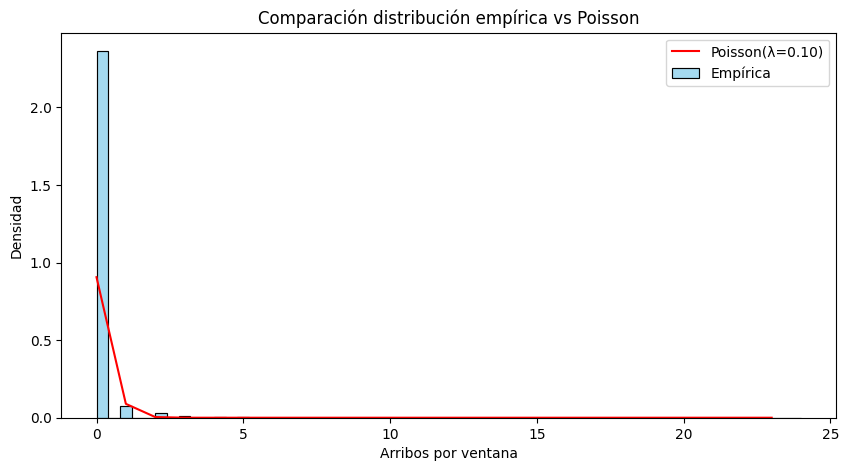

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# Datos: arribos por ventana
arribos = df_ts['arribos_count']

# Parámetro lambda estimado
lambda_hat = arribos.mean()

# Distribución empírica
plt.figure(figsize=(10,5))
sns.histplot(arribos, bins=60, stat='density', color='skyblue', label='Empírica', kde=False)

# Distribución teórica de Poisson
x = np.arange(0, arribos.max())
poisson_pmf = poisson.pmf(x, mu=lambda_hat)
plt.plot(x, poisson_pmf, 'r-', label=f'Poisson(λ={lambda_hat:.2f})')

plt.title("Comparación distribución empírica vs Poisson")
plt.xlabel("Arribos por ventana")
plt.ylabel("Densidad")
plt.legend()
plt.show()


Test de bondad de ajuste
chi cuadrado

In [ ]:
from scipy.stats import chisquare

# Histograma empírico
hist_vals, bin_edges = np.histogram(arribos, bins=np.arange(0, arribos.max()+2))
expected = poisson.pmf(np.arange(len(hist_vals)), mu=lambda_hat) * len(arribos)

chi2_stat, p_value = chisquare(hist_vals, f_exp=expected)
print(f"Chi2 = {chi2_stat:.2f}, p = {p_value:.4f}")


Chi2 = 123609756866812056722295110946481258889216.00, p = 0.0000


hora
0     0.058197
1     0.047058
2     0.029113
3     0.017305
4     0.012487
5     0.021155
6     0.039882
7     0.071822
8     0.096121
9     0.098076
10    0.087138
11    0.093747
12    0.108790
13    0.120688
14    0.124765
15    0.131263
16    0.156825
17    0.185773
18    0.206041
19    0.189770
20    0.178305
21    0.138051
22    0.091079
23    0.065694
Name: arribos_count, dtype: float64


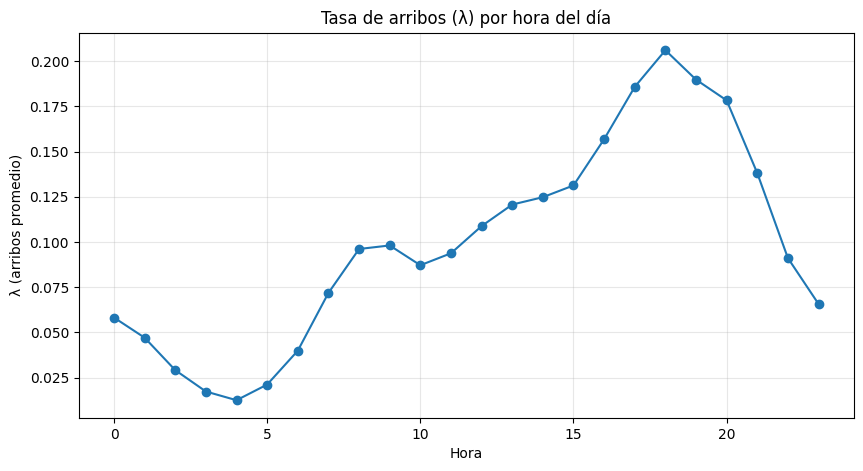

In [ ]:
import pandas as pd

# Suponiendo que ya tenés un dataframe llamado df con 'timestamp' y 'arribos_count'
df_ts['hora'] = pd.to_datetime(df_ts['timestamp']).dt.hour

# Estimar lambda por hora
lambdas_por_hora = df_ts.groupby('hora')['arribos_count'].mean()
print(lambdas_por_hora)

# Graficar lambda por hora
plt.figure(figsize=(10,5))
plt.plot(lambdas_por_hora.index, lambdas_por_hora.values, marker='o')
plt.title('Tasa de arribos (λ) por hora del día')
plt.xlabel('Hora')
plt.ylabel('λ (arribos promedio)')
plt.grid(True, alpha=0.3)
plt.show()



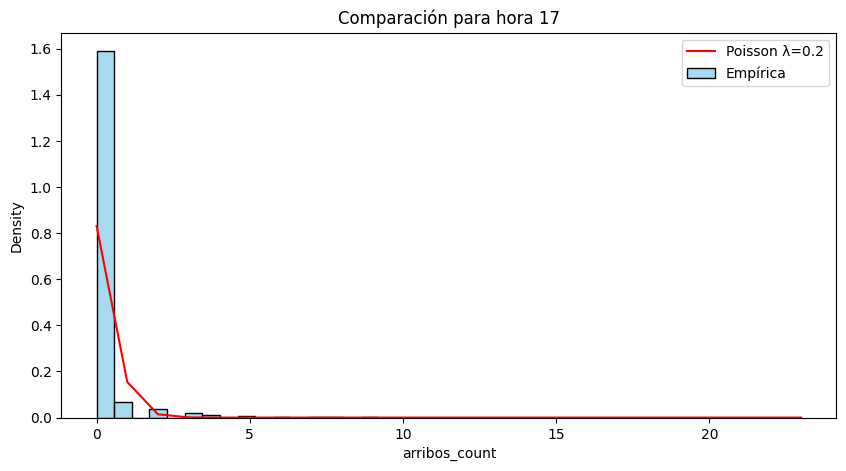

In [ ]:
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt

hora_a_ver = 17
subset = df_ts[df_ts['hora'] == hora_a_ver]['arribos_count']
lambda_h = lambdas_por_hora[hora_a_ver]

plt.figure(figsize=(10,5))
sns.histplot(subset, bins=40, stat='density', color='skyblue', label='Empírica')
x = np.arange(0, subset.max() + 1)
plt.plot(x, poisson.pmf(x, lambda_h), 'r-', label=f'Poisson λ={lambda_h:.1f}')
plt.title(f'Comparación para hora {hora_a_ver}')
plt.legend()
plt.show()


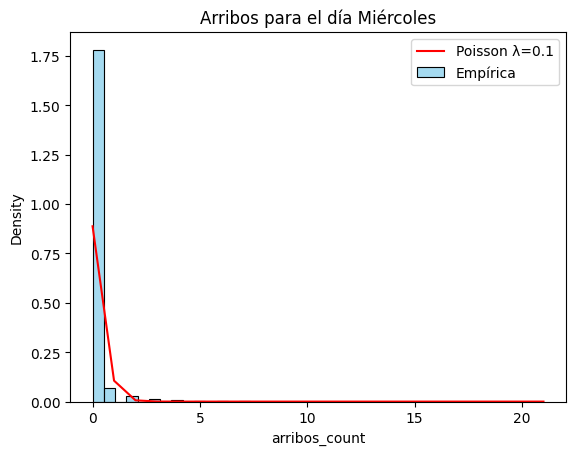

In [ ]:
df = df_ts
df['dia_semana'] = pd.to_datetime(df['timestamp']).dt.dayofweek  # 0=Lunes, 6=Domingo
lambdas_por_dia = df.groupby('dia_semana')['arribos_count'].mean()

dia = 2  # Miércoles
subset = df[df['dia_semana'] == dia]['arribos_count']
lambda_d = lambdas_por_dia[dia]

sns.histplot(subset, bins=40, stat='density', label='Empírica', color='skyblue')
x = np.arange(0, subset.max()+1)
plt.plot(x, poisson.pmf(x, lambda_d), 'r-', label=f'Poisson λ={lambda_d:.1f}')
plt.title('Arribos para el día Miércoles')
plt.legend()
plt.show()


In [ ]:
df['mes'] = pd.to_datetime(df['timestamp']).dt.month
lambdas_por_mes = df.groupby('mes')['arribos_count'].mean()

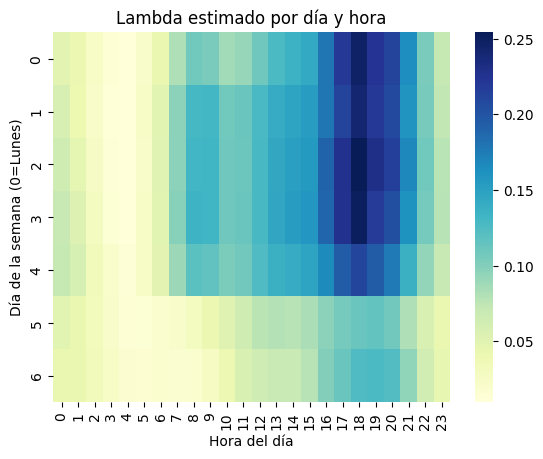

In [ ]:
grouped = df.groupby(['dia_semana', 'hora'])['arribos_count'].mean().unstack()
sns.heatmap(grouped, cmap="YlGnBu")
plt.title("Lambda estimado por día y hora")
plt.xlabel("Hora del día")
plt.ylabel("Día de la semana (0=Lunes)")
plt.show()


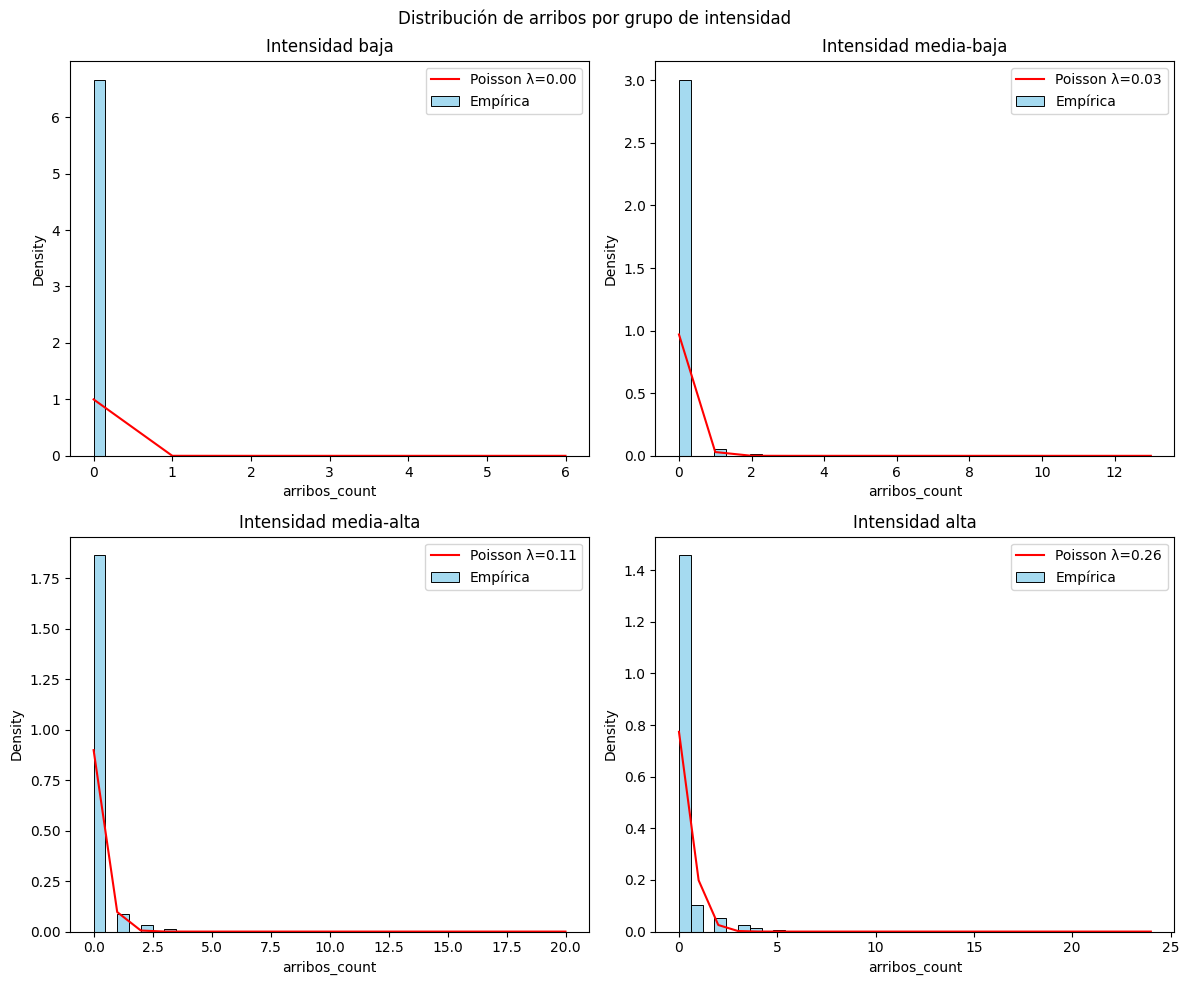

In [ ]:
# Total de arribos por estación
uso_por_estacion = df.groupby('id_estacion')['arribos_count'].sum()
df['grupo_intensidad'] = df['id_estacion'].map(uso_por_estacion)
df['grupo_intensidad'] = pd.qcut(df['grupo_intensidad'], q=4, labels=['baja', 'media-baja', 'media-alta', 'alta'])

# Crear subplots para cada grupo de intensidad
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribución de arribos por grupo de intensidad')

for (grupo, subset), ax in zip(df.groupby('grupo_intensidad'), axes.flat):
    lambda_g = subset['arribos_count'].mean()
    
    sns.histplot(data=subset, x='arribos_count', bins=40, stat='density', 
                 label='Empírica', color='skyblue', ax=ax)
    
    x = np.arange(0, subset['arribos_count'].max()+1)
    ax.plot(x, poisson.pmf(x, lambda_g), 'r-', 
            label=f'Poisson λ={lambda_g:.2f}')
    
    ax.set_title(f'Intensidad {grupo}')
    ax.legend()

plt.tight_layout()
plt.show()


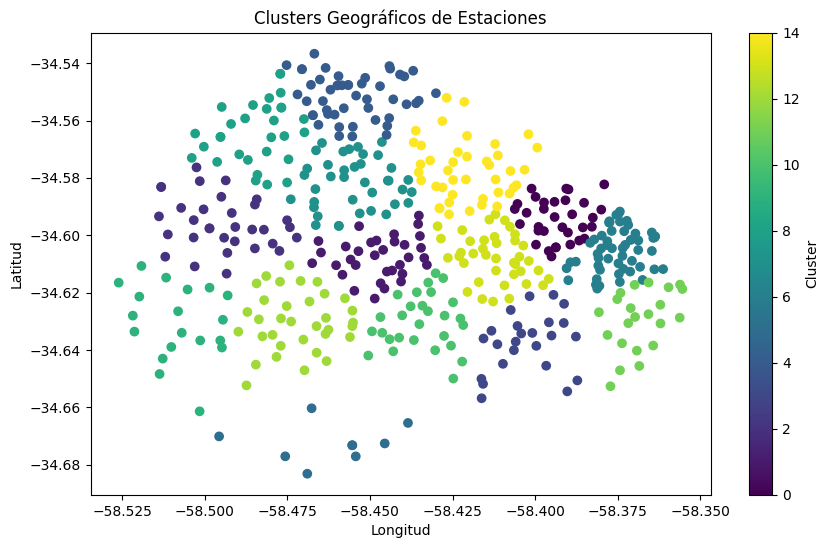

In [ ]:
from sklearn.cluster import KMeans

coords = df[['id_estacion', 'lat_estacion', 'long_estacion']].drop_duplicates()
kmeans = KMeans(n_clusters=15, random_state=42).fit(coords[['lat_estacion', 'long_estacion']])
coords['cluster_geo'] = kmeans.labels_
if 'cluster_geo' in df.columns:
    df = df.drop(columns=['cluster_geo'])

df = df.merge(coords[['id_estacion', 'cluster_geo']], on='id_estacion', how='left')

# Visualizar clusters geográficos
plt.figure(figsize=(10, 6))
plt.scatter(coords['long_estacion'], coords['lat_estacion'], 
           c=coords['cluster_geo'], cmap='viridis')
plt.title('Clusters Geográficos de Estaciones')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(label='Cluster')
plt.show()




In [ ]:
uso_por_estacion = df.groupby('id_estacion')['arribos_count'].sum()
df['grupo_intensidad'] = df['id_estacion'].map(uso_por_estacion)
df['grupo_intensidad'] = pd.qcut(df['grupo_intensidad'], q=4, labels=['baja', 'media-baja', 'media-alta', 'alta'])

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Asegurarse de que las variables categóricas estén tratadas como tales
df['hora'] = df['hora'].astype('category')
df['dia_semana'] = df['dia_semana'].astype('category')
df['mes'] = df['mes'].astype('category')
df['grupo_intensidad'] = df['grupo_intensidad'].astype('category')
df['cluster_geo'] = df['cluster_geo'].astype('category')

# Fórmula del modelo
formula = "arribos_count ~ C(hora) + C(dia_semana) + C(mes) + C(grupo_intensidad) + C(cluster_geo) + proporcion_mujeres + edad_usuario_mean + despachos_count"

# Ajustar GLM Poisson
modelo = smf.glm(formula=formula, data=df, family=sm.families.Poisson()).fit()

# Resumen del modelo
print(modelo.summary())

df


MemoryError: 

In [ ]:
df['lambda_pred'] = modelo.predict(df)
import seaborn as sns
sns.scatterplot(data=df, x='lambda_pred', y='arribos_count', alpha=0.3)
plt.plot([0, df['lambda_pred'].max()], [0, df['lambda_pred'].max()], 'r--')  # línea 45°
plt.xlabel("λ predicho")
plt.ylabel("Arribos reales")
plt.title("Predicción del modelo Poisson")
plt.show()


In [ ]:
import xgboost as xgb
cat_features = ['hora', 'dia_semana', 'mes', 'grupo_intensidad', 'cluster_geo','año','dia_mes','es_fin_semana']
num_features = ['proporcion_mujeres', 'edad_usuario_std','edad_usuario_mean', 'despachos_count','arribos_prev_count','duracion_recorrido_count','duracion_recorrido_std','duracion_recorrido_mean','long_estacion','lat_estacion','id_estacion']

X = df[cat_features + num_features].copy()

# Convierte a dummies solo las categóricas (equivale a C(...) en fórmulas)
X_encoded = pd.get_dummies(X, columns=cat_features, drop_first=True)

y = df['arribos_count']


X_encoded = pd.get_dummies(X, drop_first=True)  # Si querés usar xgb clásico

dtrain = xgb.DMatrix(X_encoded, label=y)

params = {
    'objective': 'count:poisson',
    'tree_method': 'gpu_hist',  # o 'gpu_hist' si tenés GPU
    'max_depth': 8,
    'eta': 0.1,
    'eval_metric': 'poisson-nloglik',
    'seed': 42
}

bst = xgb.train(params, dtrain, num_boost_round=100)


MAE: 0.34
RMSE: 0.69
R²: 0.410


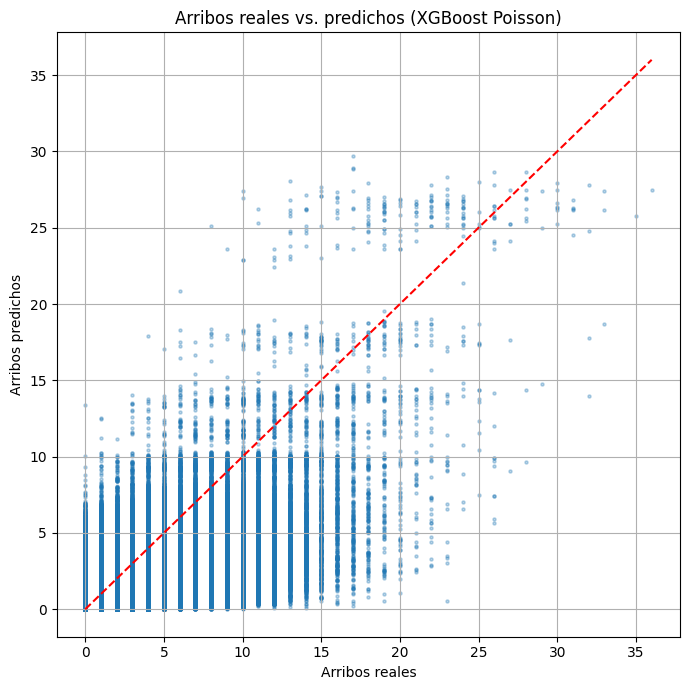

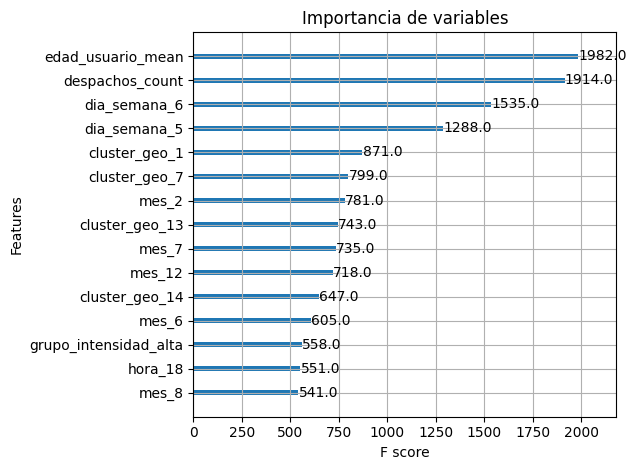

In [ ]:
y_pred = bst.predict(dtrain)  # o sobre otro X_encoded_test
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y, y_pred)
print(f"MAE: {mae:.2f}")
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE: {rmse:.2f}")
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f}")

plt.figure(figsize=(7, 7))
plt.scatter(y, y_pred, alpha=0.3, s=5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Arribos reales")
plt.ylabel("Arribos predichos")
plt.title("Arribos reales vs. predichos (XGBoost Poisson)")
plt.grid(True)
plt.tight_layout()
plt.show()

xgb.plot_importance(bst, max_num_features=15)
plt.title("Importancia de variables")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [ ]:
bst = xgb.train(params, dtrain, num_boost_round=100)

In [ ]:
y_pred = bst.predict(dtest)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Evaluación en Test:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")


Evaluación en Test:
MAE: 0.34
RMSE: 0.69
R²: 0.410


In [17]:
import gc
gc.collect()

0

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain=xgb.DMatrix(X_encoded, label=y),
    num_boost_round=100,
    nfold=5,
    metrics=['poisson-nloglik'],
    seed=42,
    as_pandas=True,
    verbose_eval=False,
)

print(cv_results.tail())
cv_results[['train-poisson-nloglik-mean', 'test-poisson-nloglik-mean']].plot(figsize=(10, 5))
plt.title("Poisson-NLogLik: Train vs Test")
plt.xlabel("Ronda de boosting")
plt.ylabel("Poisson-Negative Log-Likelihood")
plt.grid()
plt.show()


MemoryError: Unable to allocate 16.2 GiB for an array with shape (60, 36208773) and data type object

In [ ]:
best_round = cv_results['test-poisson-nloglik-mean'].idxmin()
best_score = cv_results.loc[best_round, 'test-poisson-nloglik-mean']
print(f"Mejor ronda: {best_round} con Poisson-NLogLik promedio en test: {best_score:.4f}")


Mejor ronda: 99 con Poisson-NLogLik promedio en test: 0.5145


In [ ]:
final_model = xgb.train(
    params,
    dtrain=xgb.DMatrix(X_encoded, label=y),
    num_boost_round=best_round
)


In [ ]:
dtest = xgb.DMatrix(X_encoded)  # O nuevos datos con las mismas columnas
y_pred = final_model.predict(dtest)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
poisson_nloglik = -np.mean(y * np.log(y_pred + 1e-6) - y_pred)  # misma fórmula que XGBoost

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Poisson NLogLik (manual): {poisson_nloglik:.4f}")


RMSE: 0.47
MAE: 0.33
R²: 0.4213
Poisson NLogLik (manual): 0.3655


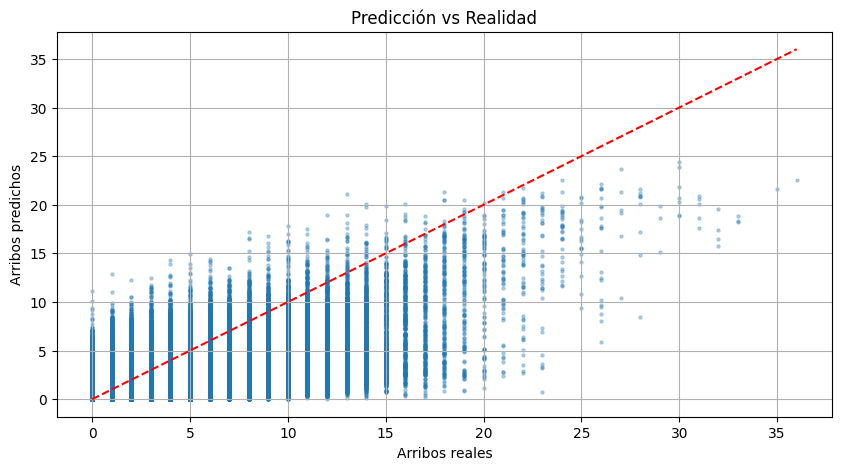

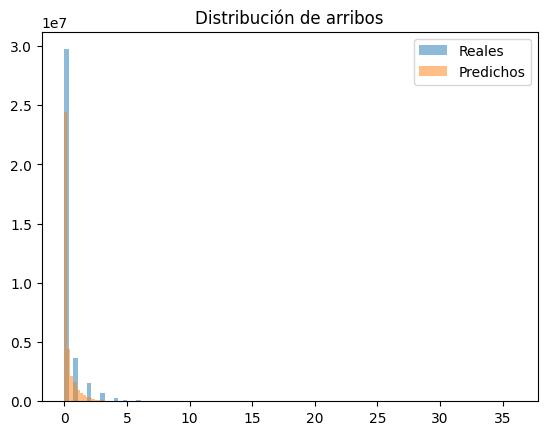

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y, y_pred, alpha=0.3, s=5)
plt.plot([0, y.max()], [0, y.max()], color='red', linestyle='--')
plt.xlabel("Arribos reales")
plt.ylabel("Arribos predichos")
plt.title("Predicción vs Realidad")
plt.grid()
plt.show()

plt.hist(y, bins=100, alpha=0.5, label="Reales")
plt.hist(y_pred, bins=100, alpha=0.5, label="Predichos")
plt.legend()
plt.title("Distribución de arribos")
plt.show()


In [ ]:
y_pred_cero = np.zeros_like(y_test)
print("Evaluación del modelo que predice siempre 0:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_cero):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_cero)):.2f}")
print(f"R²: {r2_score(y_test, y_pred_cero):.3f}")

Evaluación del modelo que predice siempre 0:
MAE: 0.33
RMSE: 0.96
R²: -0.132
